(mmm_example)=
# MMM Example Notebook

In this notebook we work out a simulated example to showcase the media mix Model (MMM) API from `pymc-marketing`. This package provides a `pymc` implementation of the MMM presented in the paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/). We work with synthetic data as we want to do *parameter recovery* to better understand the model assumptions. That is, we explicitly set values for our adstock and saturation parameters (see model specification below) and recover them back from the model. The data generation process is as an adaptation of the blog post ["Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/) by [Juan Orduz](https://juanitorduz.github.io/).

## Business Problem

Before jumping into the data, let's first define the business problem we are trying to solve. We are a marketing agency and we want to optimize the marketing budget of a client. We have access to the following data:

- Sales data: weekly sales of the client.
- Media spend data: weekly spend on different media channels (e.g. TV, radio, online, etc.). In ths example we consider 2 media channels: $x_{1}$ and $x_{2}$.
- Domain knowledge: 
  - We know that there has a been an positive sales trend which we believe comes from a strong economic growth.
  - We also know that there is a yearly seasonality effect.
  - In addition, we were informed about two outliers in the data during the weeks `2019-05-13` and `2021-09-14`.

What do we mean by optimize the marketing budget? We want to find the optimal media mix that maximizes sales. In order to do so, we need to understand the mechanism in which the media spend for each channel affects sales. In other words, we need to understand the media contribution. The main challenge is that the direct cost signal does not translate into a linear contribution. For example, a $10\%$ increase in channel $x_{1}$ spend does not necessarily translate into a $10\%$ increase in sales. This can be explained by two phenomena

1. On the one hand side, there is a carry-over effect. That is, the effect of spend on sales is not instantaneous but accumulates over time.
2. In addition, there is a saturation effect. That is, the effect of spend on sales is not linear but saturates at some point.

In this example we will illustrate how we can use `pymc-marketing` to model these effects.

In the next section we describe a general framework for modeling media effects.

## Model Specification

In `pymc-marketing` we provide an API for a Bayesian media mix model (MMM) specification following [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017).](https://research.google/pubs/pub46001/). Concretely, given a time series target variable $y_{t}$ (e.g. sales or conversions), media variables $x_{m, t}$ (e.g. impressions, clicks or costs) and a set of control covariates $z_{c, t}$ (e.g. holidays, special events) we consider a linear model of the form 

$$
y_{t} = \alpha + \sum_{m=1}^{M}\beta_{m}f(x_{m, t}) +  \sum_{c=1}^{C}\gamma_{c}z_{c, t} + \varepsilon_{t},
$$

where $\alpha$ is the intercept, $f$ is a media transformation function and $\varepsilon_{t}$ is the error therm which we assume is normally distributed. The function $f$ encodes the contribution of media on the target variable. Typically we consider two types of transformation: adstock (carry-over) and saturation effects.

### References:

- [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017).](https://research.google/pubs/pub46001/)
- PyMC Labs Blog:
  - [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
  - [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)
- [Johns, Michael and Wang,  Zhenyu. "A Bayesian Approach to Media Mix Modeling"](https://www.youtube.com/watch?v=UznM_-_760Y)
- [Orduz, Juan. "Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/)

---

## Part I: Data Generation Process

In Part I of this notebook we focus on the data generating process. That is, we want to construct the target variable $y_{t}$ (sales) by adding each of the components described in the *Business Problem* section.

## Prepare Notebook

In [55]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.utils import generate_fourier_modes

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

### 1. Date Range

First we set a time range for our data. We consider a bit more than 2 years of data at weekly granularity.

In [56]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


### 2. Media Costs Data

Now we generate synthetic data from two channels $x_1$ and $x_2$. We refer to it as the raw signal as it is going to be the input at the modeling phase. We expect the contribution of each channel to be different, based on the carryover and saturation parameters.

- Raw Signal

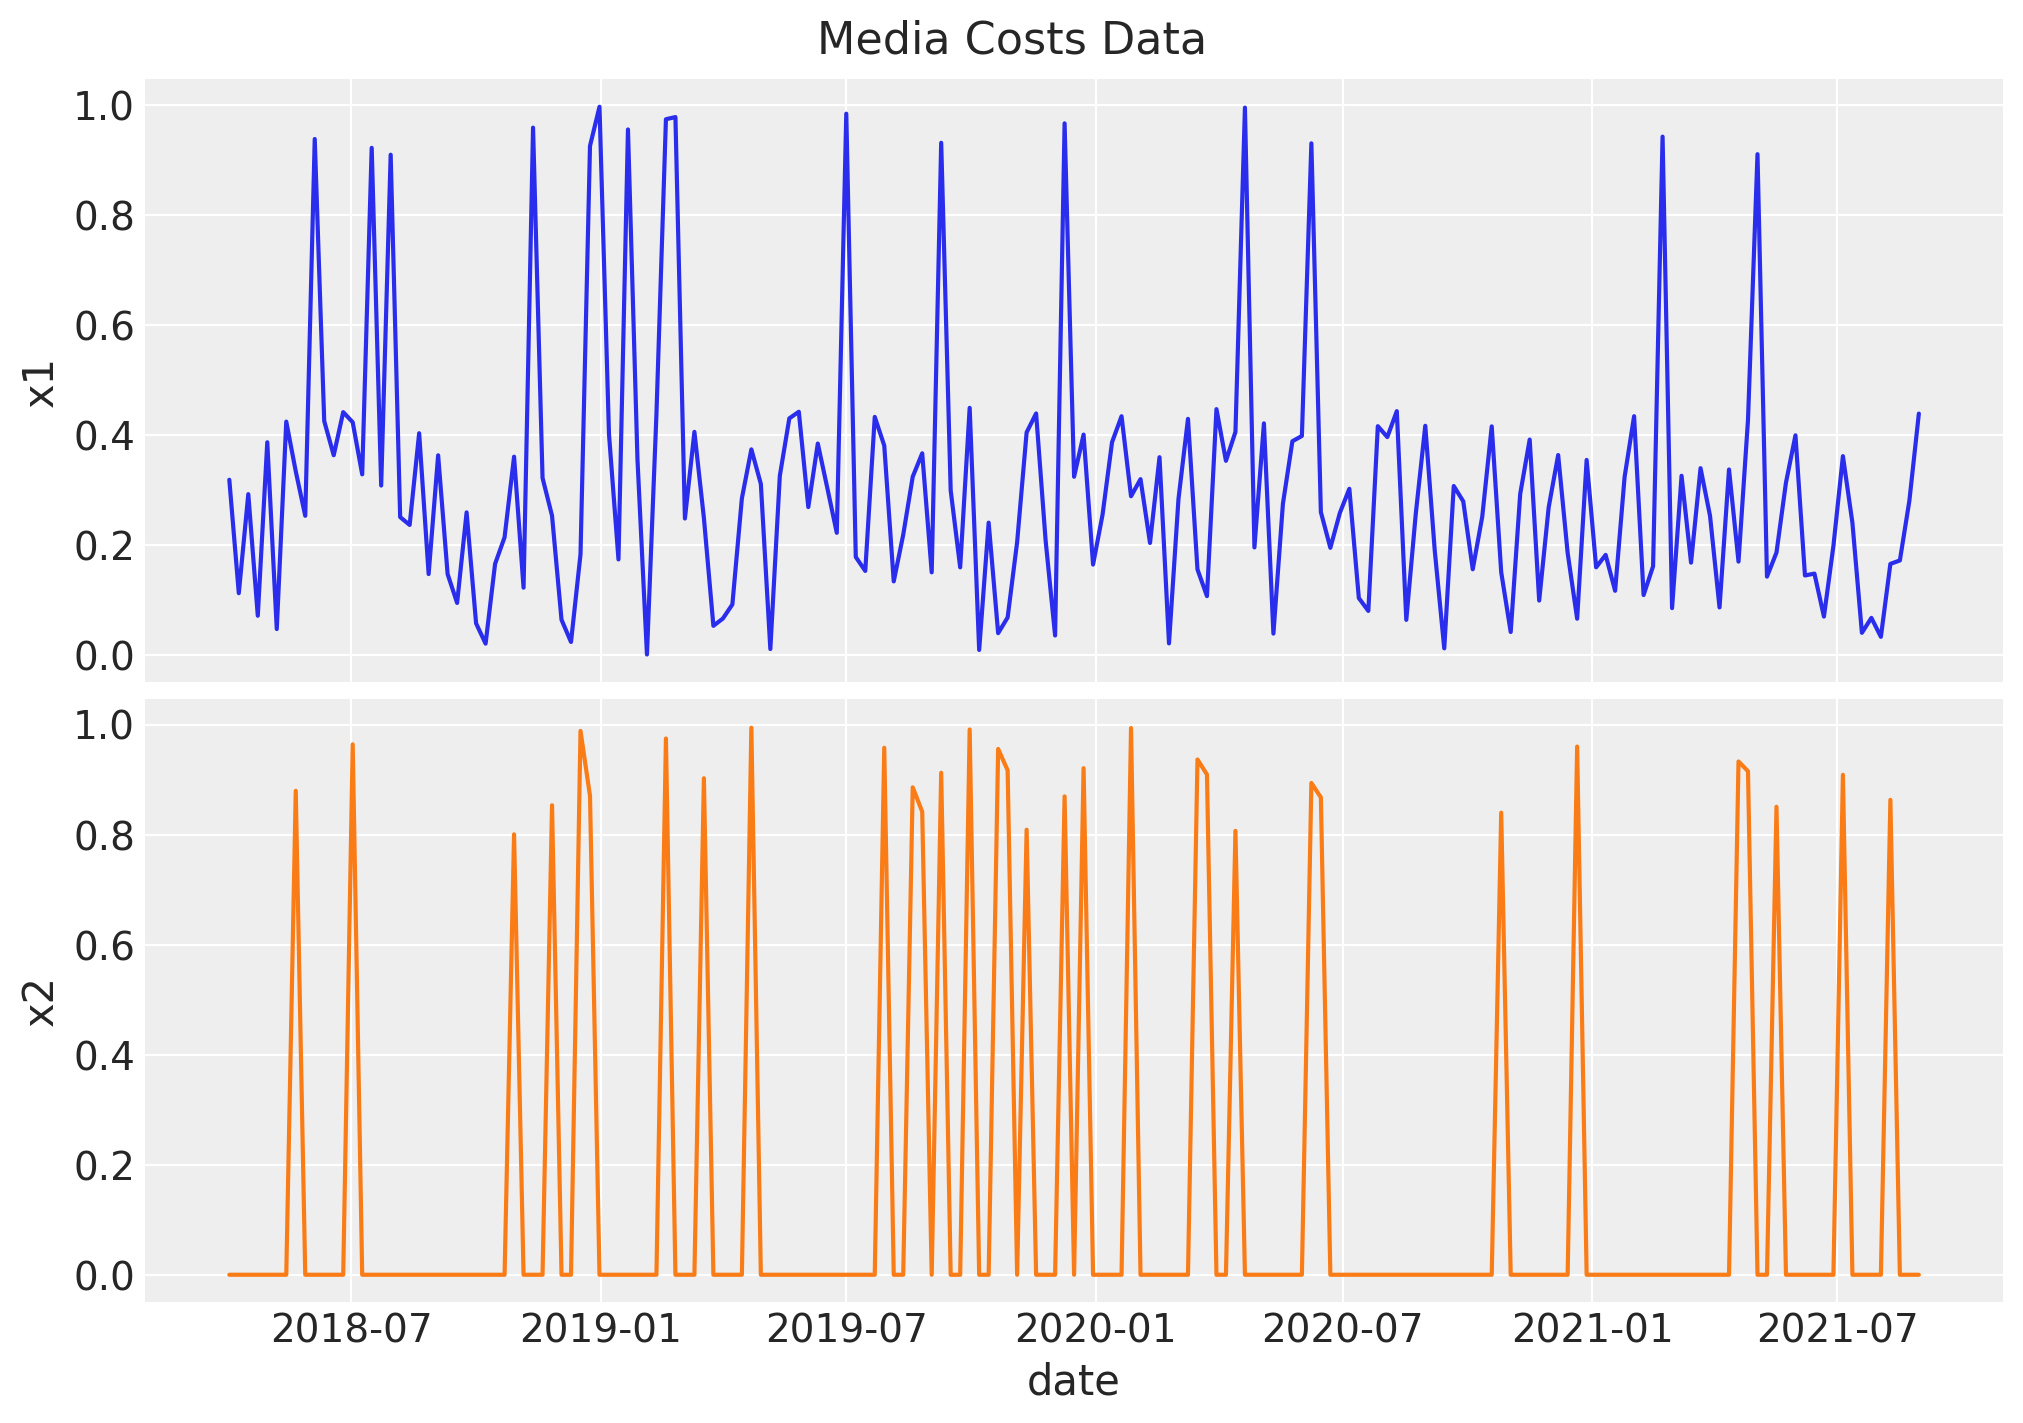

In [57]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

**Remark:** By design, $x_{1}$ should resemble a typical paid social channel and $x_{2}$ a offline (e.g. TV) spend time series.

- Effect Signal

Next, we pass the raw signal through the two transformations: first the geometric adstock (carryover effect) and then the logistic saturation. Note that we set the parameters ourselves, but we will recover them back from the model.

Let's start with the adstock transformation. We set the adstock parameter $0 < \alpha < 1$ to be $0.4$ and $0.2$ for $x_1$ and $x_2$ respectively. We set a maximum lag effect of $8$ weeks.

In [58]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(
        x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True
    )
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(
        x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True
    )
    .eval()
    .flatten()
)

Next, we compose the resulting adstock signals with the logistic saturation function. We set the parameter $\lambda > 0$ to be $4$ and $3$ for $z_1$ and $z_2$ respectively.

In [59]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

We can now visualize the effect signal for each channel after each transformation:

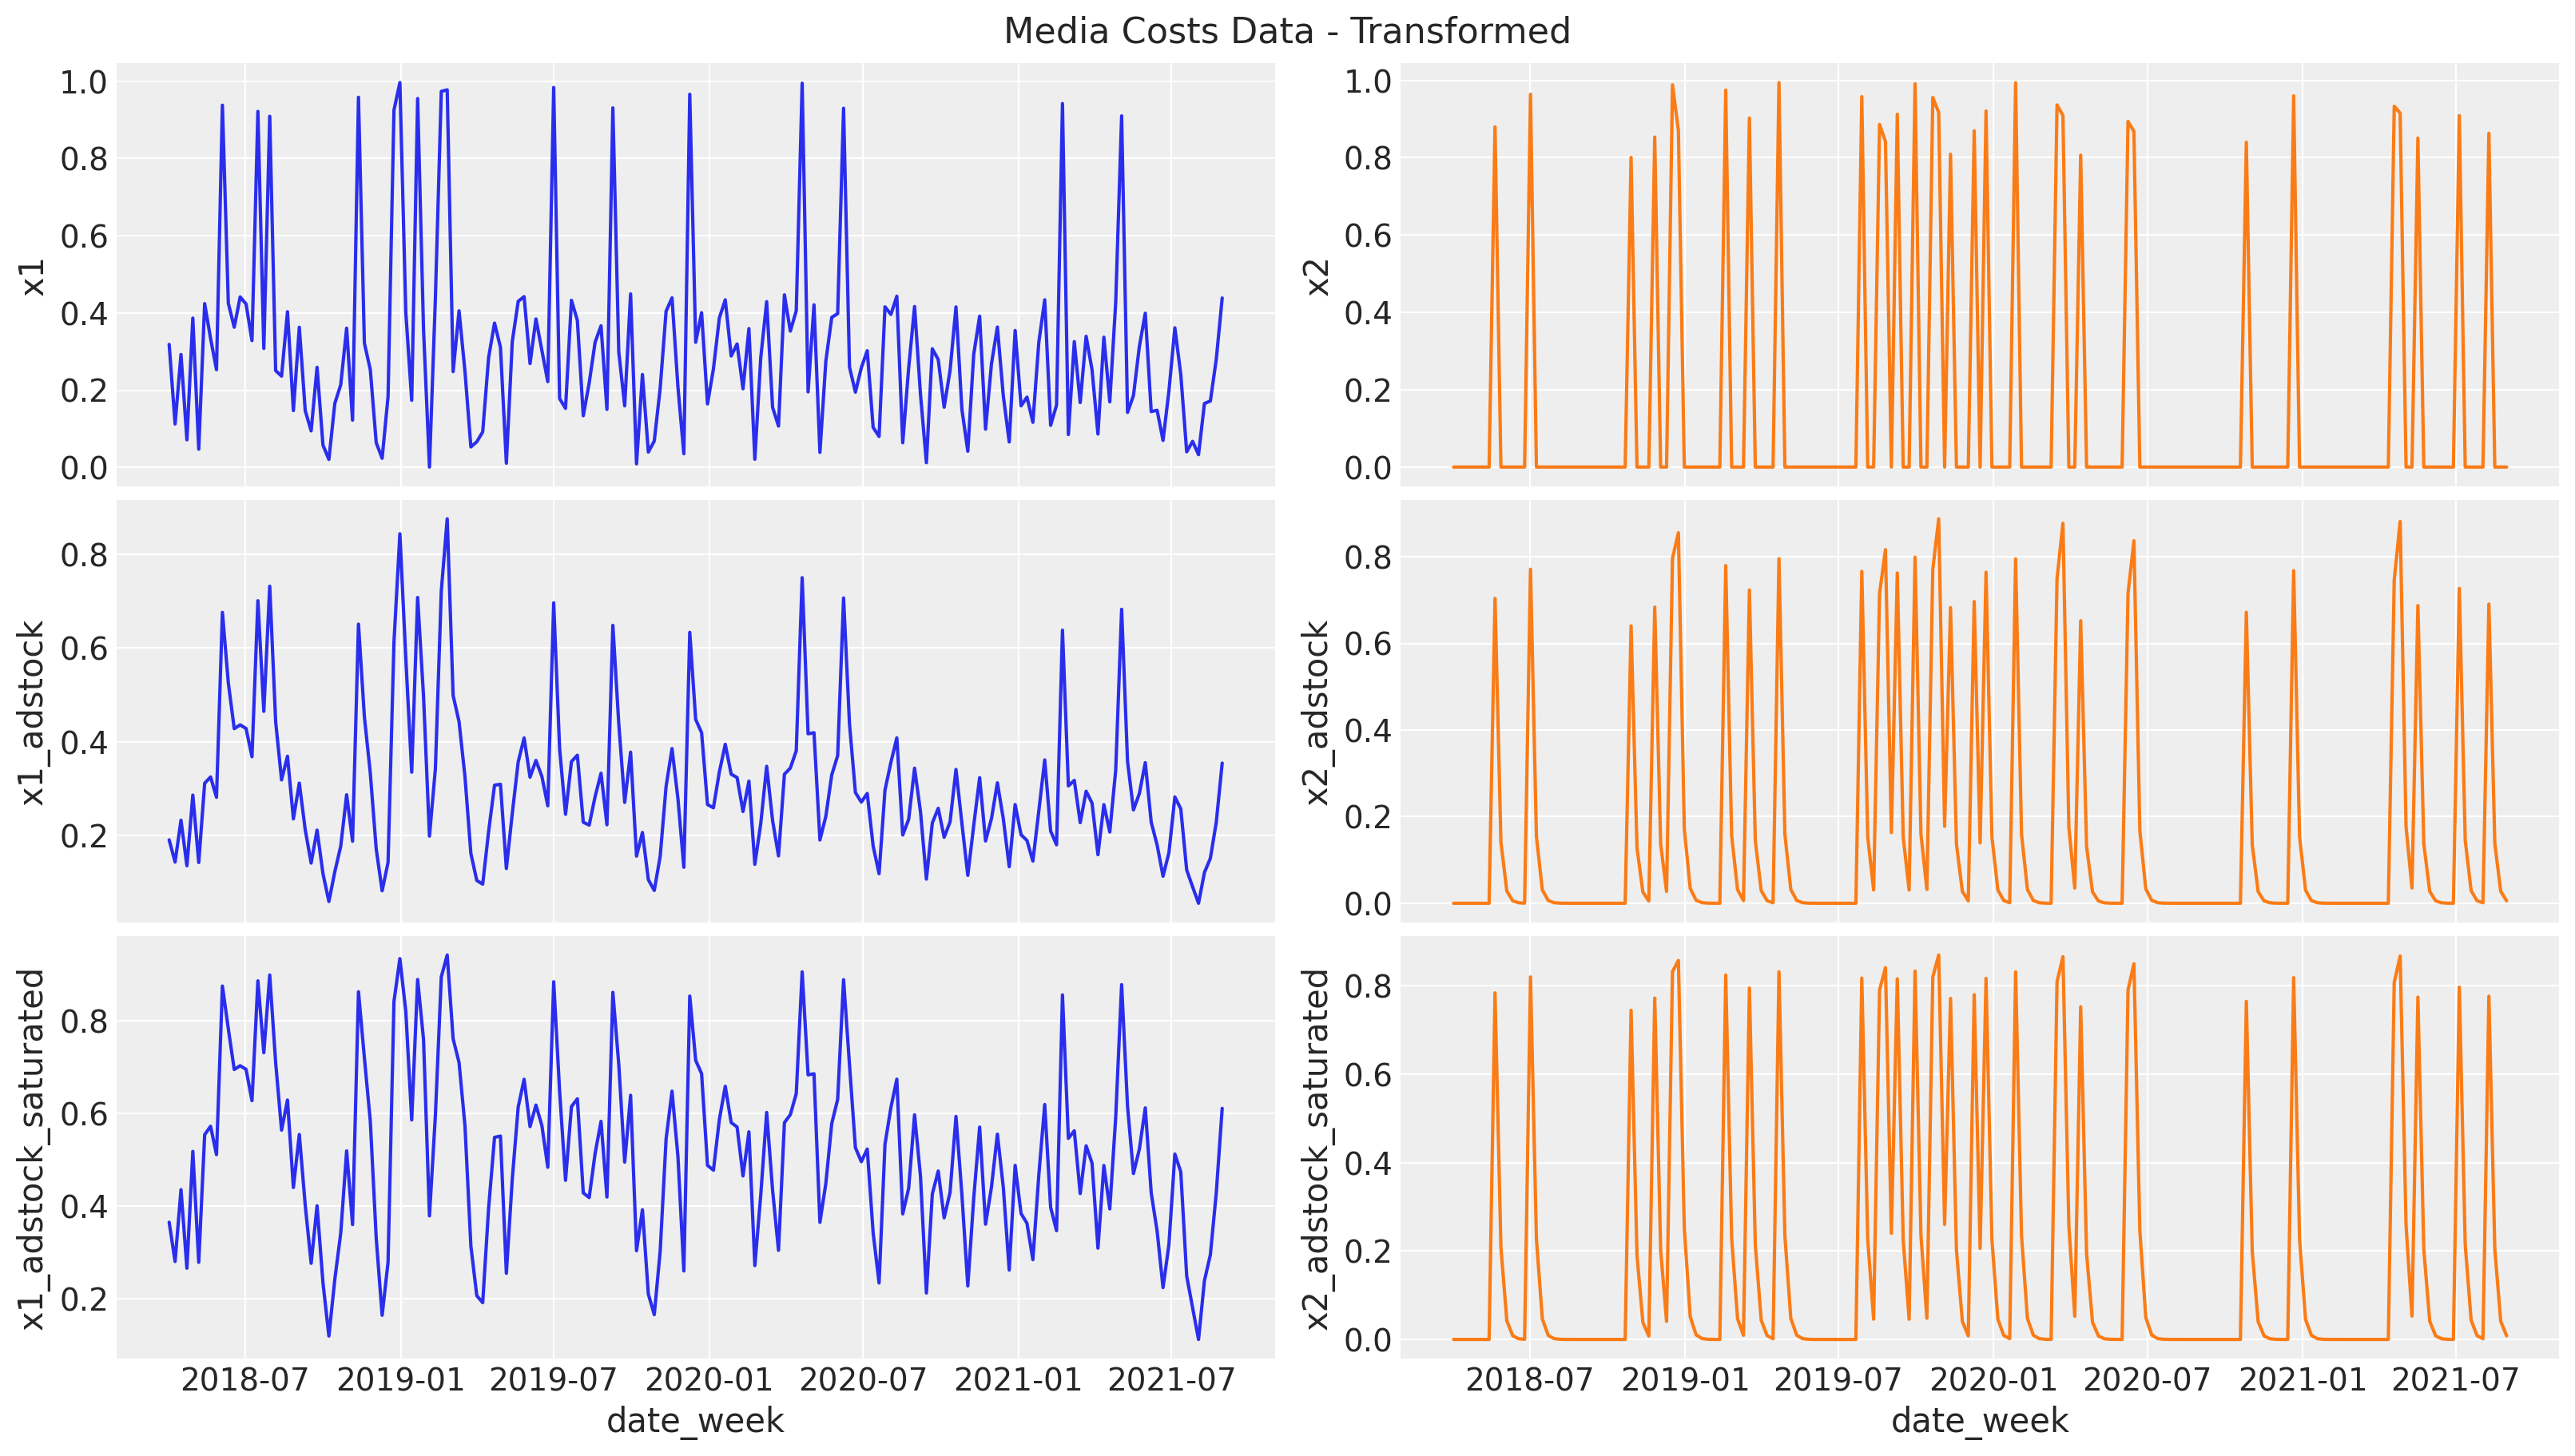

In [60]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

### 3. Trend \& Seasonal Components

Now we add synthetic trend and seasonal components to the effect signal.

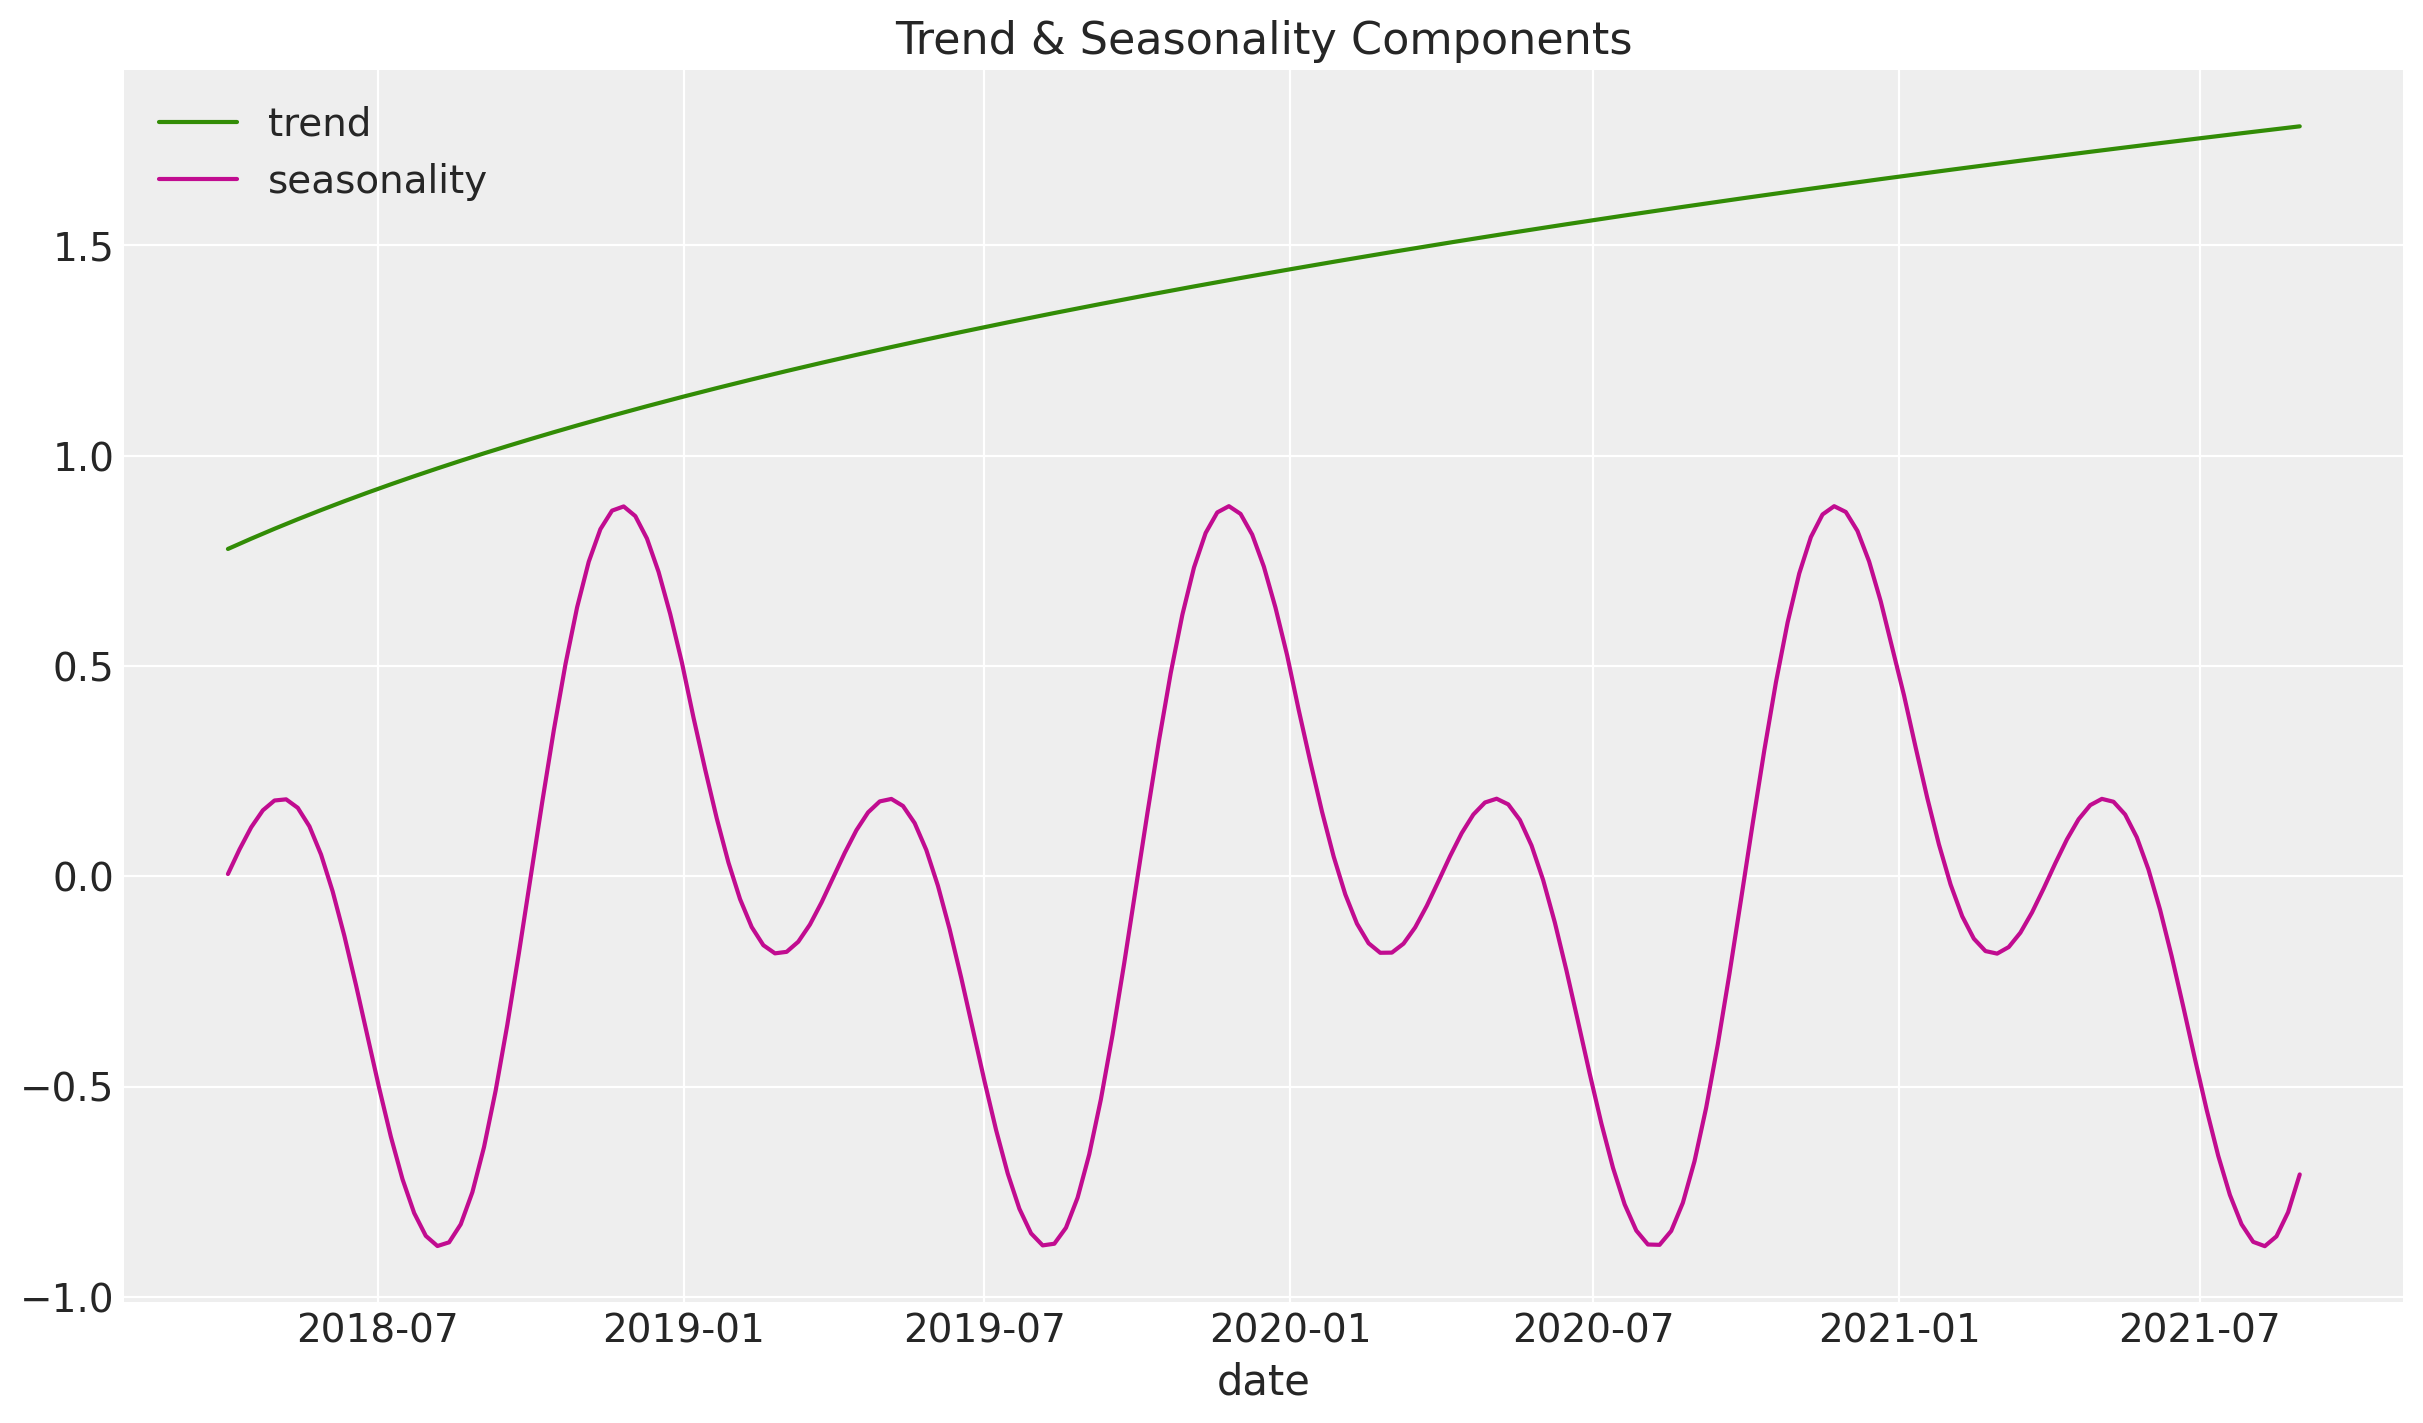

In [61]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = - np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5) 
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

### 4. Control Variables

We add two *events* where there was a remarkable peak in our target variable. We assume they are independent an not seasonal (e.g. launch of a particular product). 

In [62]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

### 5. Target Variable

Finally, we define the target variable (sales) $y$. We assume it is a linear combination of the effect signal, the trend and the seasonal components, plus the two events and an intercept. We also add some Gaussian noise.

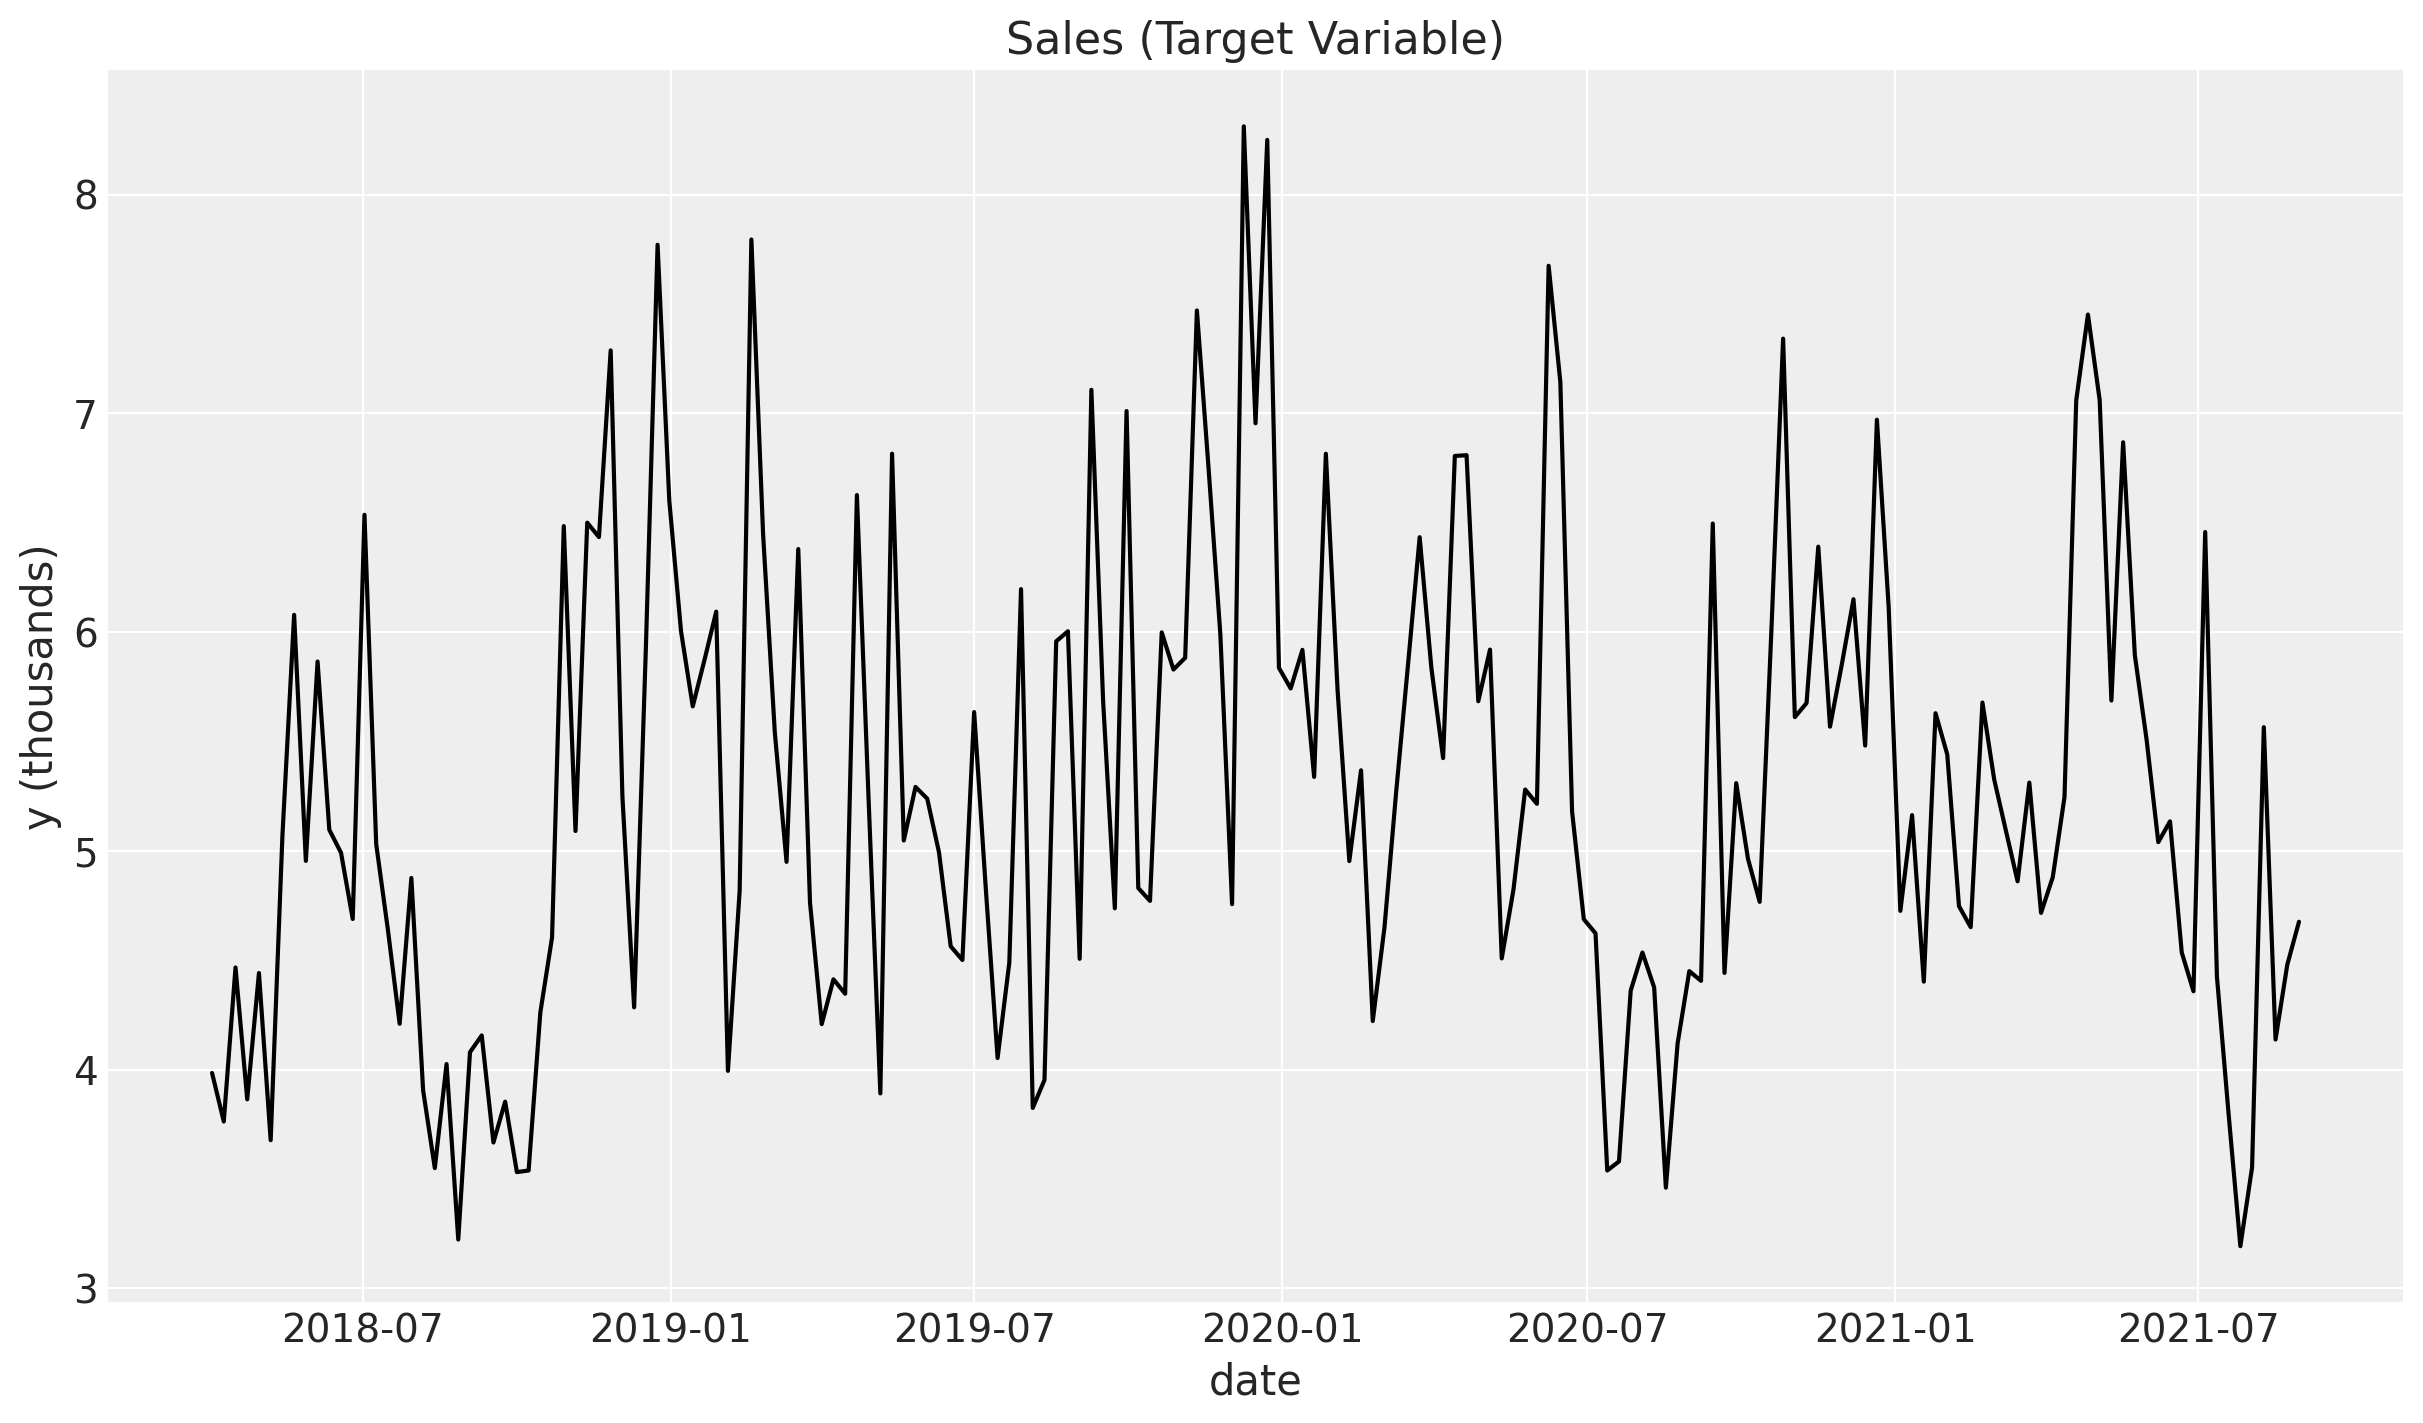

In [63]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

### 6. Media Contribution Interpretation

From the data generating process we can compute the relative contribution of each channel to the target variable. We will recover these values back from the model.

In [64]:
contribution_share_x1: float = (
    (beta_1 * df["x1_adstock_saturated"]).sum()
    / (beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]).sum()
)

contribution_share_x2: float = (
    (beta_2 * df["x2_adstock_saturated"]).sum()
    / (beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]).sum()
)

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.81
Contribution Share of x2: 0.19


We can obtain the contribution plots for each channel where we clearly see the effect of the adstock and saturation transformations.

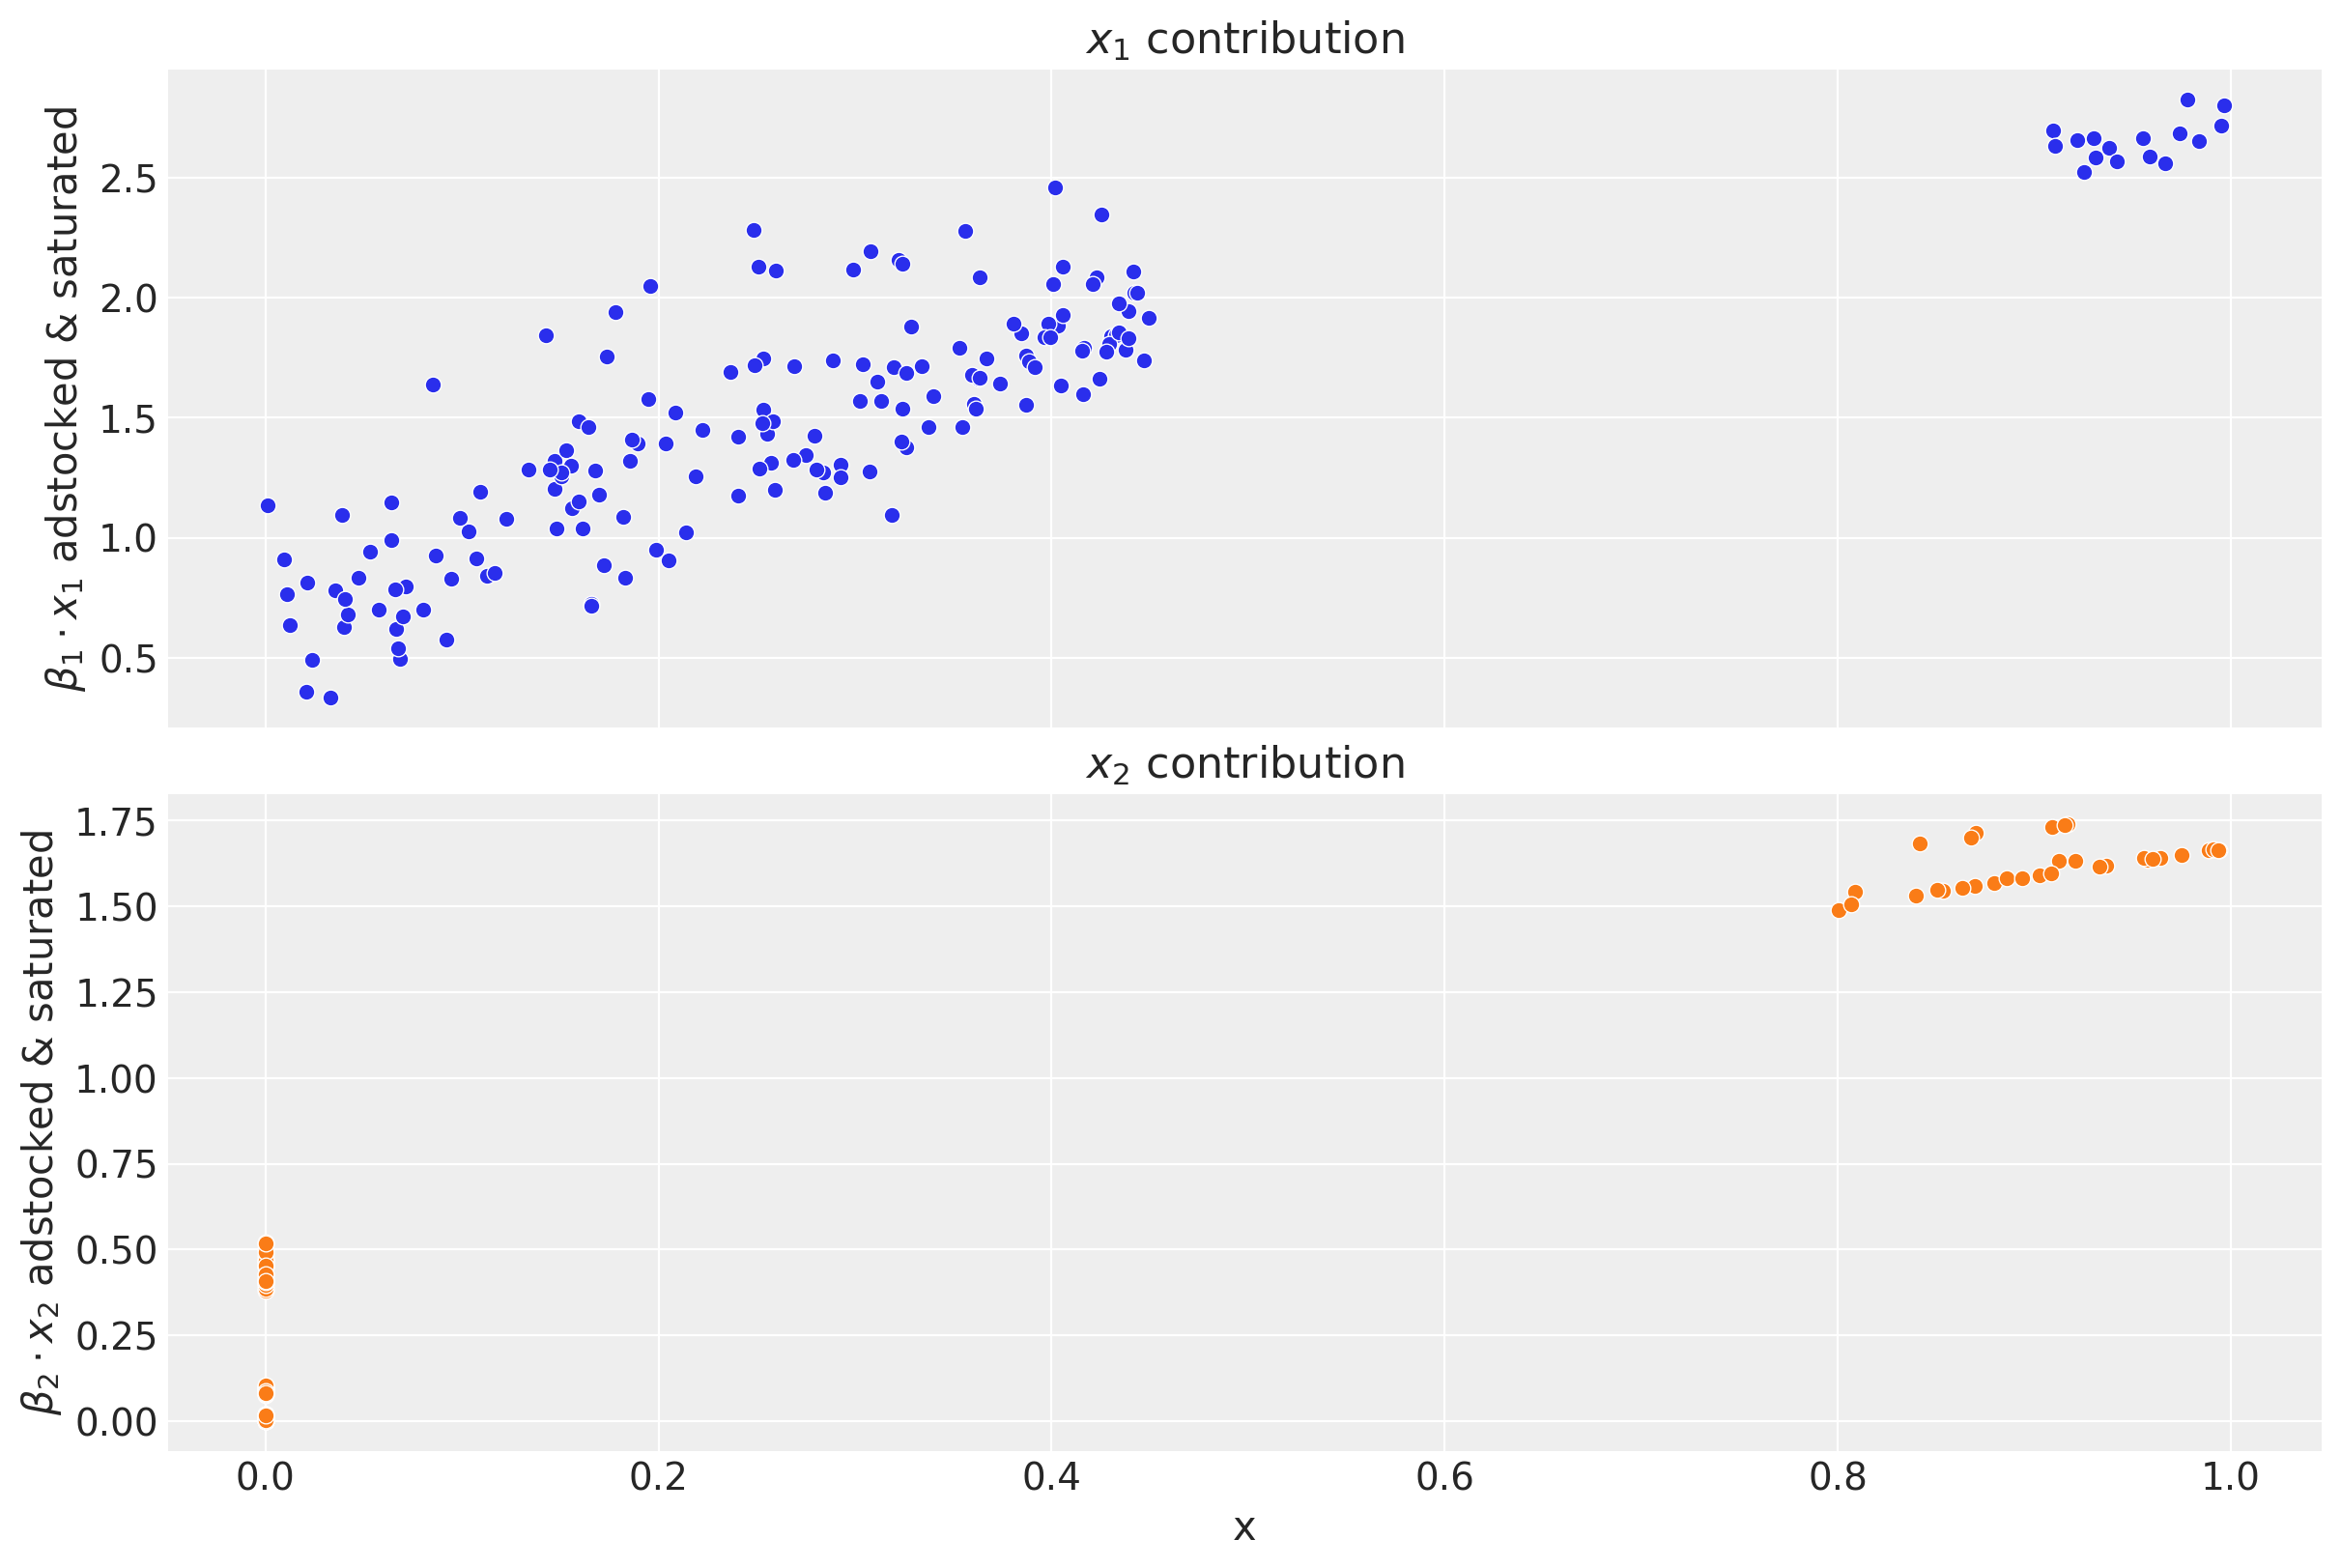

In [65]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

This plot shows some interesting aspects of the media contribution: 

- The adstock effect is reflected in the non-zero contribution of the channel even when the spend is zero.
- One clearly see the saturation effect as the contribution growth (slope) decreases as the spend increases.

As we will see in Part II of this notebook, we will recover these plots from the model!

We see that channel $x_{1}$ has a higher contribution than $x_{2}$. This could be explained by the fact that there was more spend in channel  $x_{1}$ than in channel $x_{2}$:

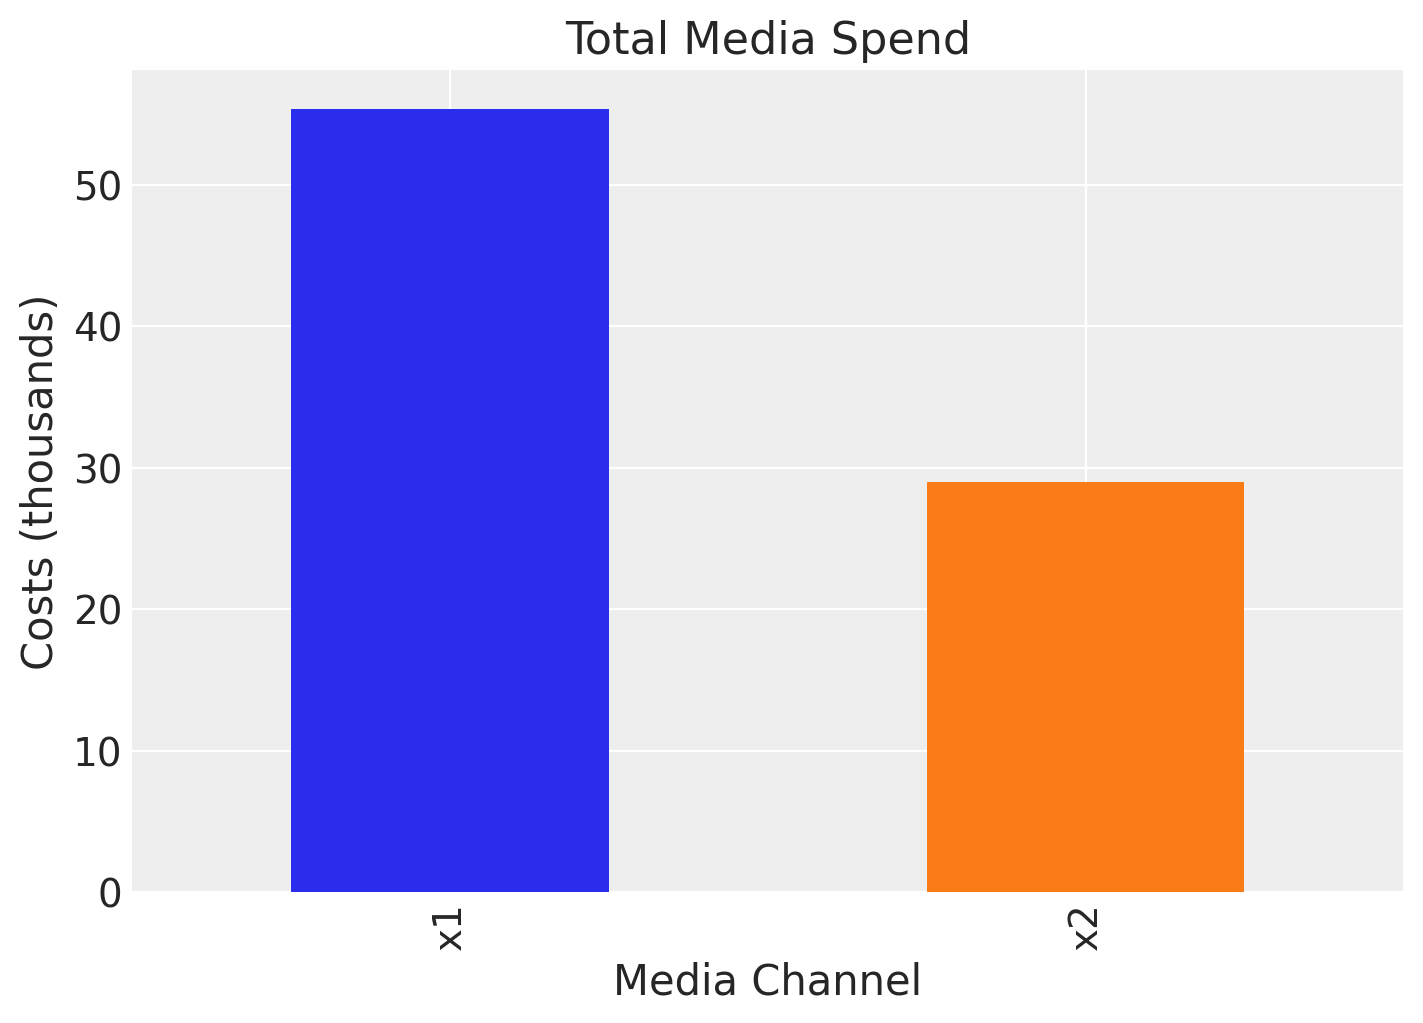

In [66]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2"]].sum().plot(kind="bar", color=["C0", "C1"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");

However, one usually is not only interested in the contribution itself but rather the Return on Ad Spend (ROAS). That is, the contribution divided by the cost. We can compute the ROAS for each channel as follows:

In [67]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

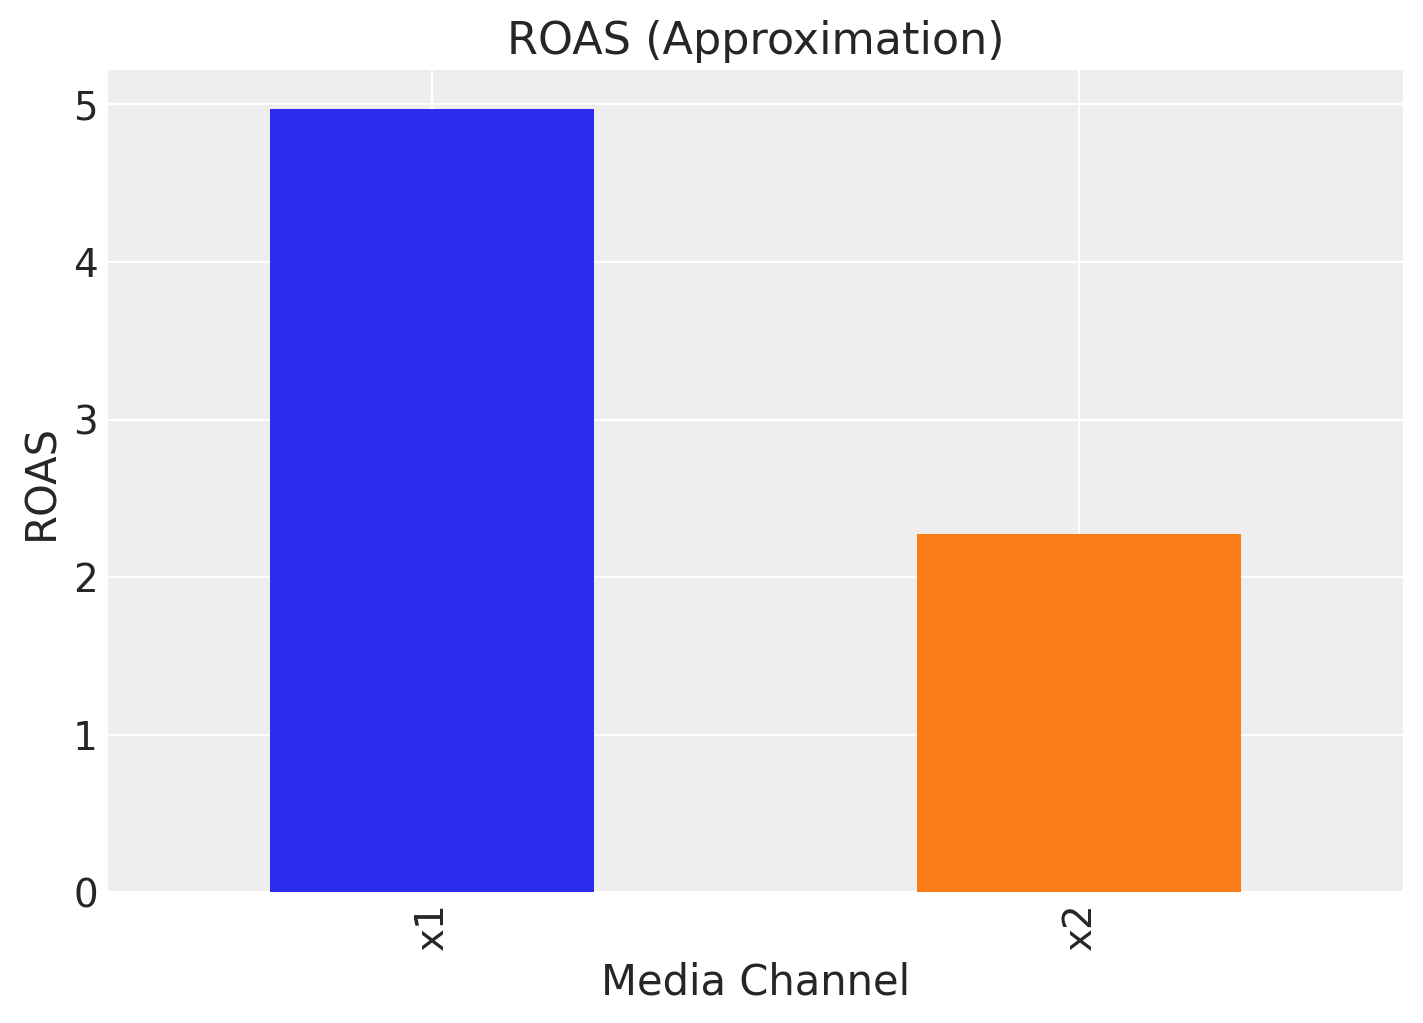

In [68]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"])
    .plot(kind="bar", color=["C0", "C1"])
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

That is, channel $x_{1}$ seems to be more efficient than channel $x_{2}$.

**Remark:** We recommended reading Section 4.1 in [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/) for a detailed explanation of the ROAS (and mROAS). In particular:
- If we transform our target variable $y$ (e.g. with a log transformation), one needs to be careful with the ROAS computation as setting the spend to zero does not commute with the transformation.
- One has to be careful with the adstock effect so that we include a carryover period to fully account for the effect of the spend. The ROAS estimation above is an approximation.

### 7. Data Output

We of course will not have all of these features in our real data. Let's filter out the features we will use for modeling:

In [69]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

date_week         y        x1   x2  event_1  event_2  dayofyear
0 2018-04-02  3.984662  0.318580  0.0      0.0      0.0         92
1 2018-04-09  3.762872  0.112388  0.0      0.0      0.0         99
2 2018-04-16  4.466967  0.292400  0.0      0.0      0.0        106
3 2018-04-23  3.864219  0.071399  0.0      0.0      0.0        113
4 2018-04-30  4.441625  0.386745  0.0      0.0      0.0        120

---

## Part II: Modeling

On this second part, we focus on the modeling process. We will use the data generated in Part I.

## 1. Feature Engineering

Assuming we did an EDA and we have a good understanding of the data (we did not do it here as we generated the data ourselves, but please never skip the EDA!), we can start building our model. One thing we immediately see is the seasonality and the trend component. We can generate features ourselves as *control variables* (we expect to have a trend and seasonality components in the model API in future releases).

- For the seasonality component we use Fourier modes (similar as in [Prophet](https://facebook.github.io/prophet/)). We use 4 modes for the seasonality component.
- For thr trend component we simply use a linear trend.

In [70]:
# Fourier modes
fourier_modes = generate_fourier_modes(
    periods=data["dayofyear"] / 365.25,
    n_order=2
)

# trend feature

data["t"] = range(n)

data = pd.concat([data, fourier_modes], axis=1)

data.head()

date_week         y        x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3.984662  0.318580  0.0      0.0      0.0         92  0   
1 2018-04-09  3.762872  0.112388  0.0      0.0      0.0         99  1   
2 2018-04-16  4.466967  0.292400  0.0      0.0      0.0        106  2   
3 2018-04-23  3.864219  0.071399  0.0      0.0      0.0        113  3   
4 2018-04-30  4.441625  0.386745  0.0      0.0      0.0        120  4   

   sin_order_1  cos_order_1  sin_order_2  cos_order_2  
0     0.999930    -0.011826    -0.023651    -0.999720  
1     0.991269    -0.131859    -0.261414    -0.965227  
2     0.968251    -0.249981    -0.484089    -0.875019  
3     0.931210    -0.364483    -0.678820    -0.734304  
4     0.880683    -0.473706    -0.834370    -0.551205

## 2. Model Specification

Now that we have the data in place, lets use the `DelayedSaturatedMMM` class to define the model.

In [71]:
mmm = DelayedSaturatedMMM(
    data=data,
    target_column="y",
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
    adstock_max_lag=8,
)

You can access `pymc` model as `mmm.model`.

In [72]:
type(mmm.model)

pymc.model.Model

We can easily see the explicit model structure:

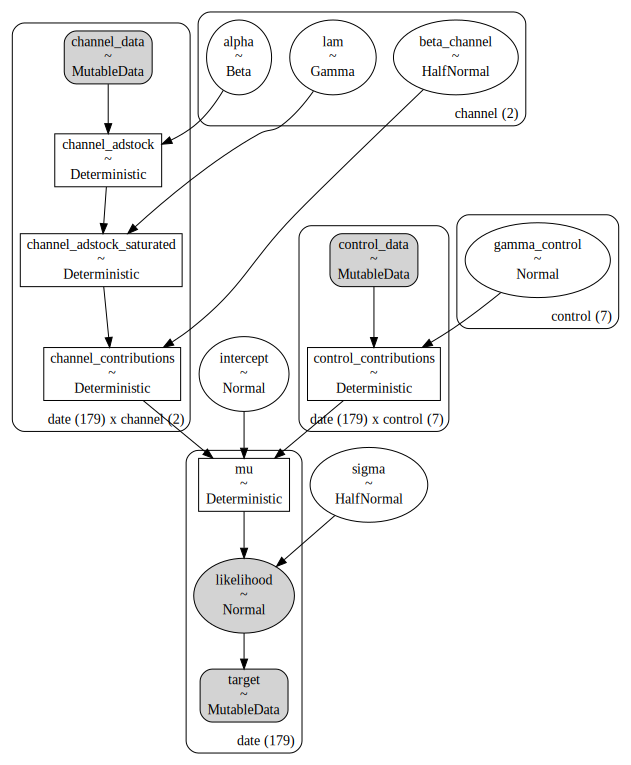

In [73]:
pm.model_to_graphviz(model=mmm.model)

Observe how the media transformations were handled by the class `DelayedSaturatedMMM`.

## 3. Model Fitting

We can now fit the model:

In [74]:
mmm.fit(target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


## 4. Model Diagnostics

The `fit_result` attribute contains the `pymc` trace object.

In [75]:
mmm.fit_result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

We can therefore use all the `pymc` machinery to run model diagnostics. First, let's see the summary of the trace:

In [76]:
az.summary(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                   0.349  0.013   0.325    0.372      0.000    0.000   
beta_channel[x1]            0.362  0.018   0.326    0.392      0.000    0.000   
beta_channel[x2]            0.267  0.077   0.193    0.368      0.002    0.002   
alpha[x1]                   0.398  0.029   0.345    0.453      0.000    0.000   
alpha[x2]                   0.191  0.040   0.112    0.263      0.001    0.001   
lam[x1]                     4.072  0.359   3.431    4.780      0.006    0.004   
lam[x2]                     3.187  1.139   1.280    5.374      0.027    0.019   
gamma_control[event_1]      0.246  0.032   0.189    0.309      0.000    0.000   
gamma_control[event_2]      0.327  0.031   0.265    0.383      0.000    0.000   
gamma_control[t]            0.001  0.000   0.001    0.001      0.000    0.000   
gamma_control[sin_order_1]  0.003  0.003  -0.003    0.009      0.000    0.000   
gamma_control[cos_order_1]  0.063  0.003   0.057    0.069      0.000    0.000   
gamma_control[sin_order_2] -0.057  0.003  -0.064   -0.051      0.000    0.000   
gamma_control[cos_order_2]  0.002  0.003  -0.005    0.008      0.000    0.000   
sigma                       0.030  0.002   0.027    0.033      0.000    0.000   

                            ess_bulk  ess_tail  r_hat  
intercept                     3494.0    2870.0    1.0  
beta_channel[x1]              3109.0    2894.0    1.0  
beta_channel[x2]              1732.0    1401.0    1.0  
alpha[x1]                     3800.0    3200.0    1.0  
alpha[x2]                     2428.0    2112.0    1.0  
lam[x1]                       3802.0    2915.0    1.0  
lam[x2]                       1721.0    1384.0    1.0  
gamma_control[event_1]        6230.0    2841.0    1.0  
gamma_control[event_2]        4803.0    3008.0    1.0  
gamma_control[t]              3766.0    3036.0    1.0  
gamma_control[sin_order_1]    4485.0    3133.0    1.0  
gamma_control[cos_order_1]    5043.0    2883.0    1.0  
gamma_control[sin_order_2]    5010.0    2915.0    1.0  
gamma_control[cos_order_2]    4407.0    3110.0    1.0  
sigma                         4572.0    2754.0    1.0

Observe that the estimated parameters for $\alpha$ and $\lambda$ are very close to the ones we set in the data generation process! Let's plot the trace for the parameters:

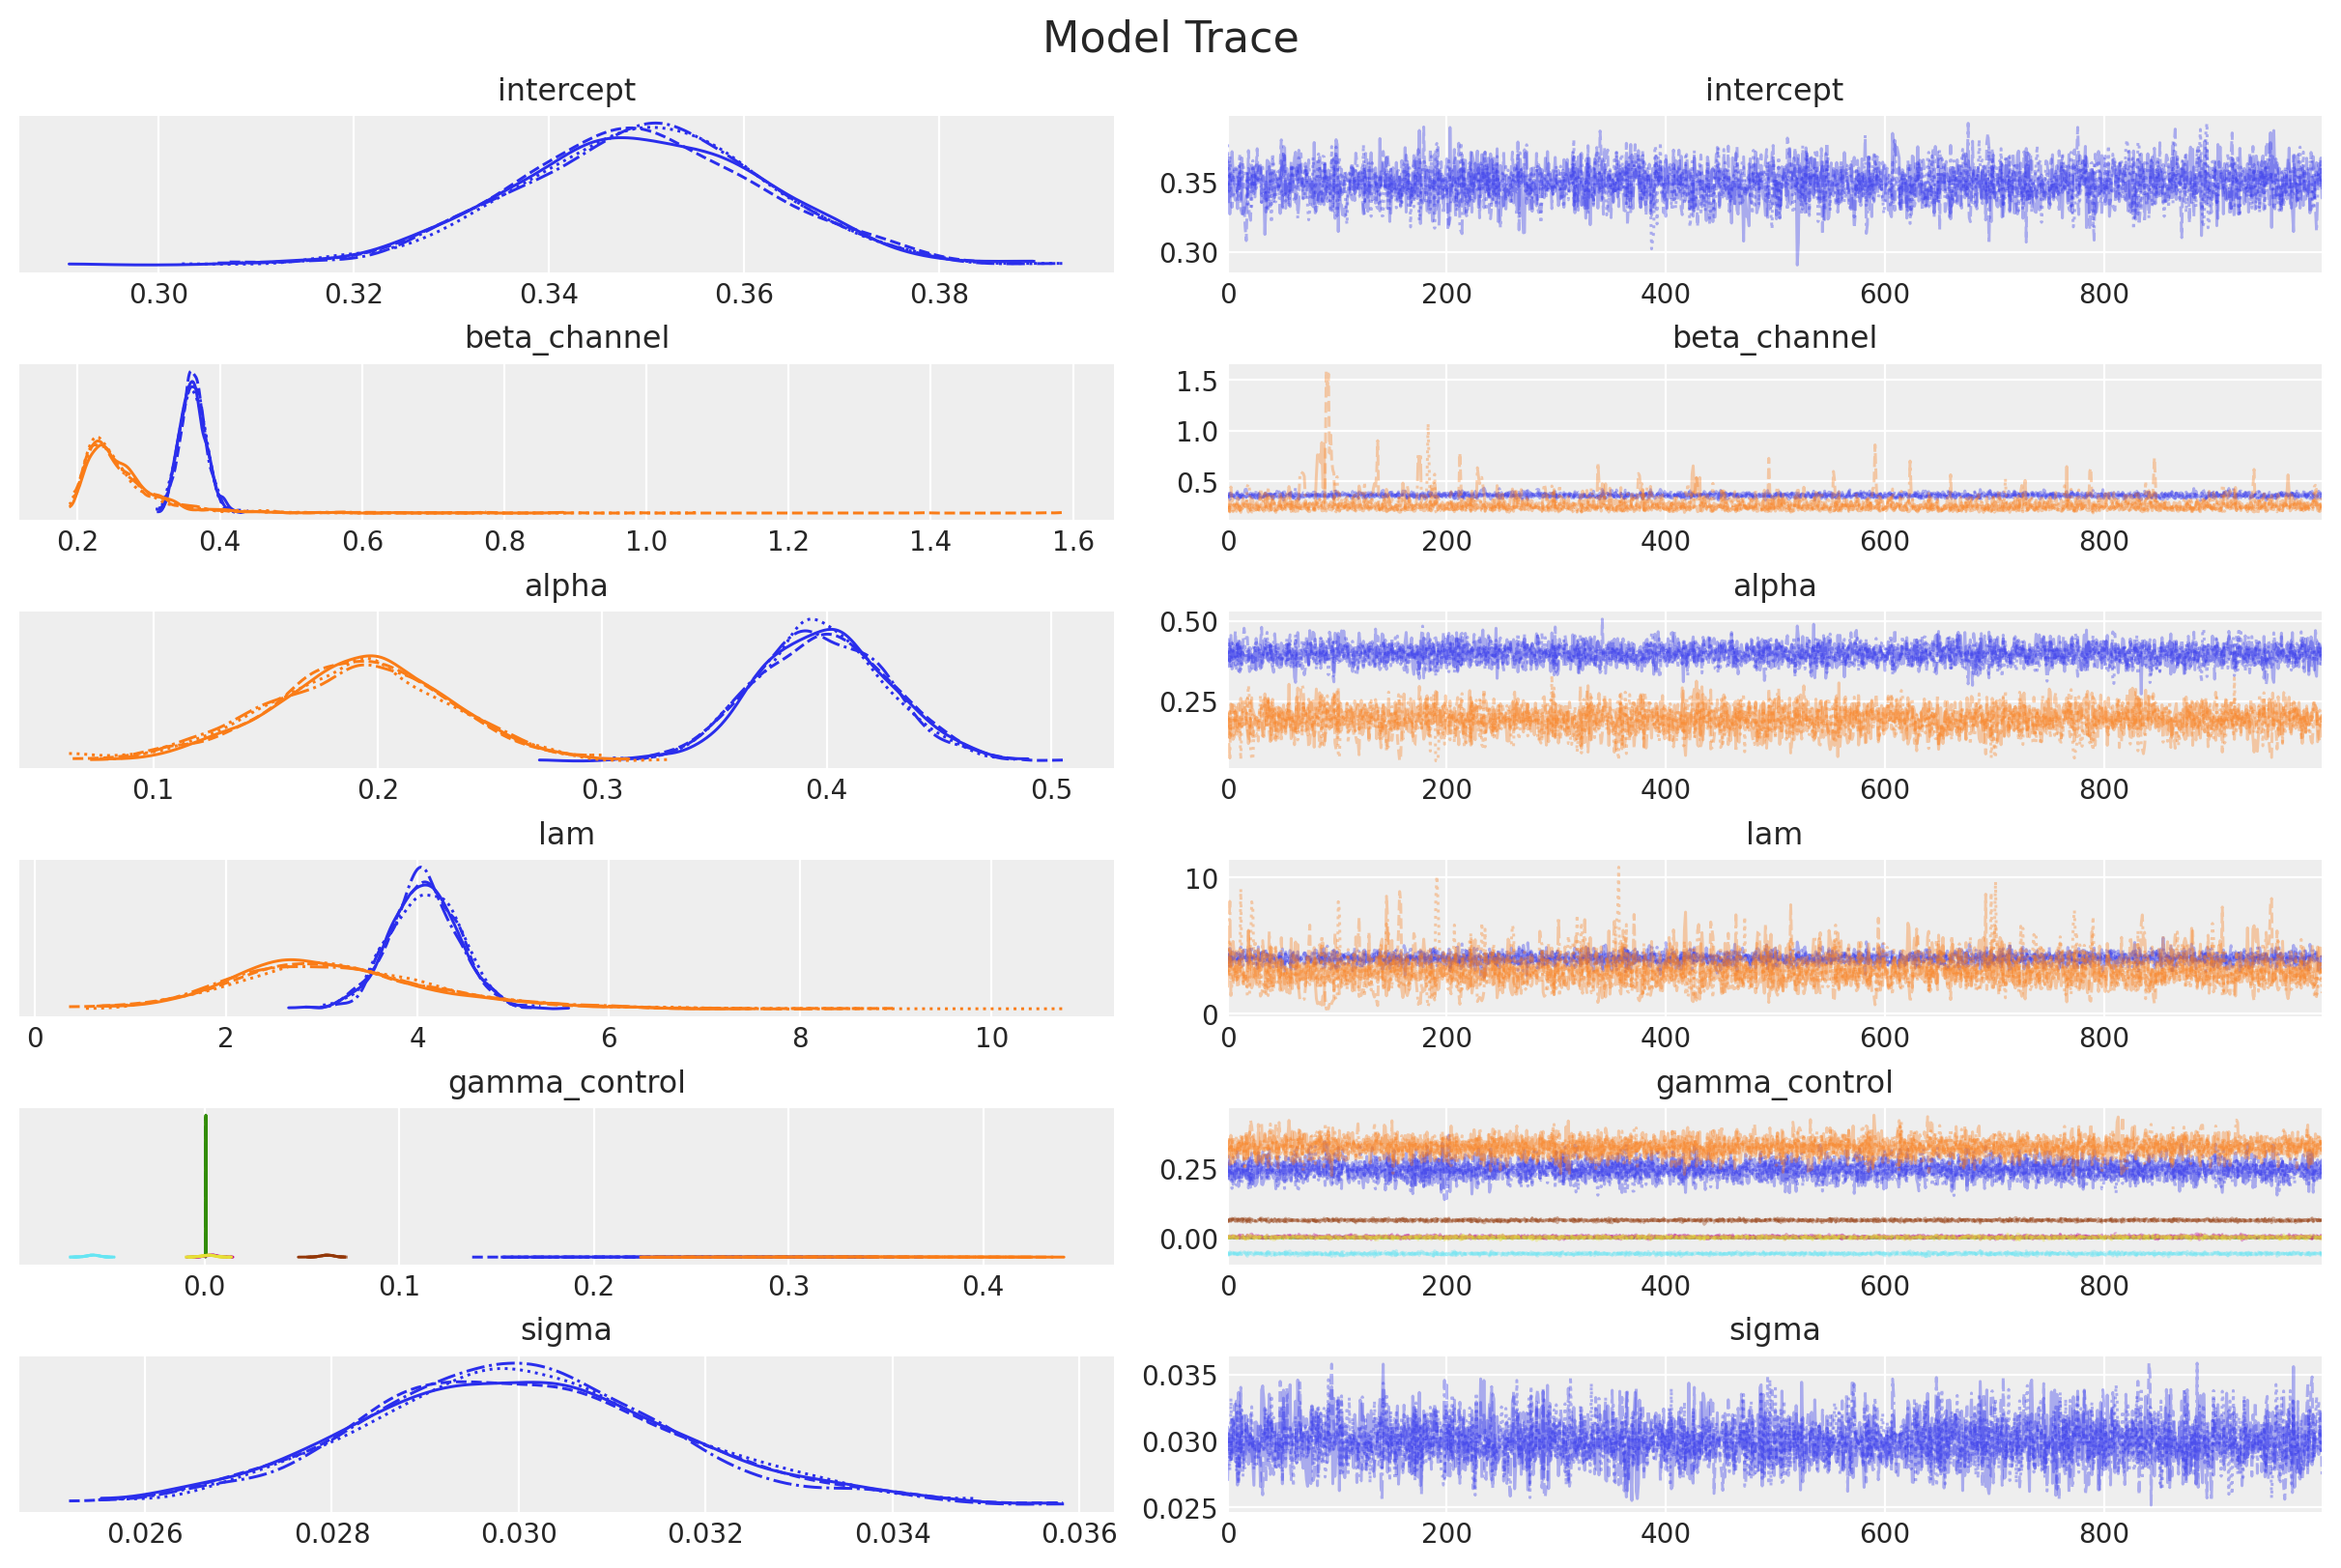

In [77]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

Next, we can plot the posterior predictive distribution for the target variable:

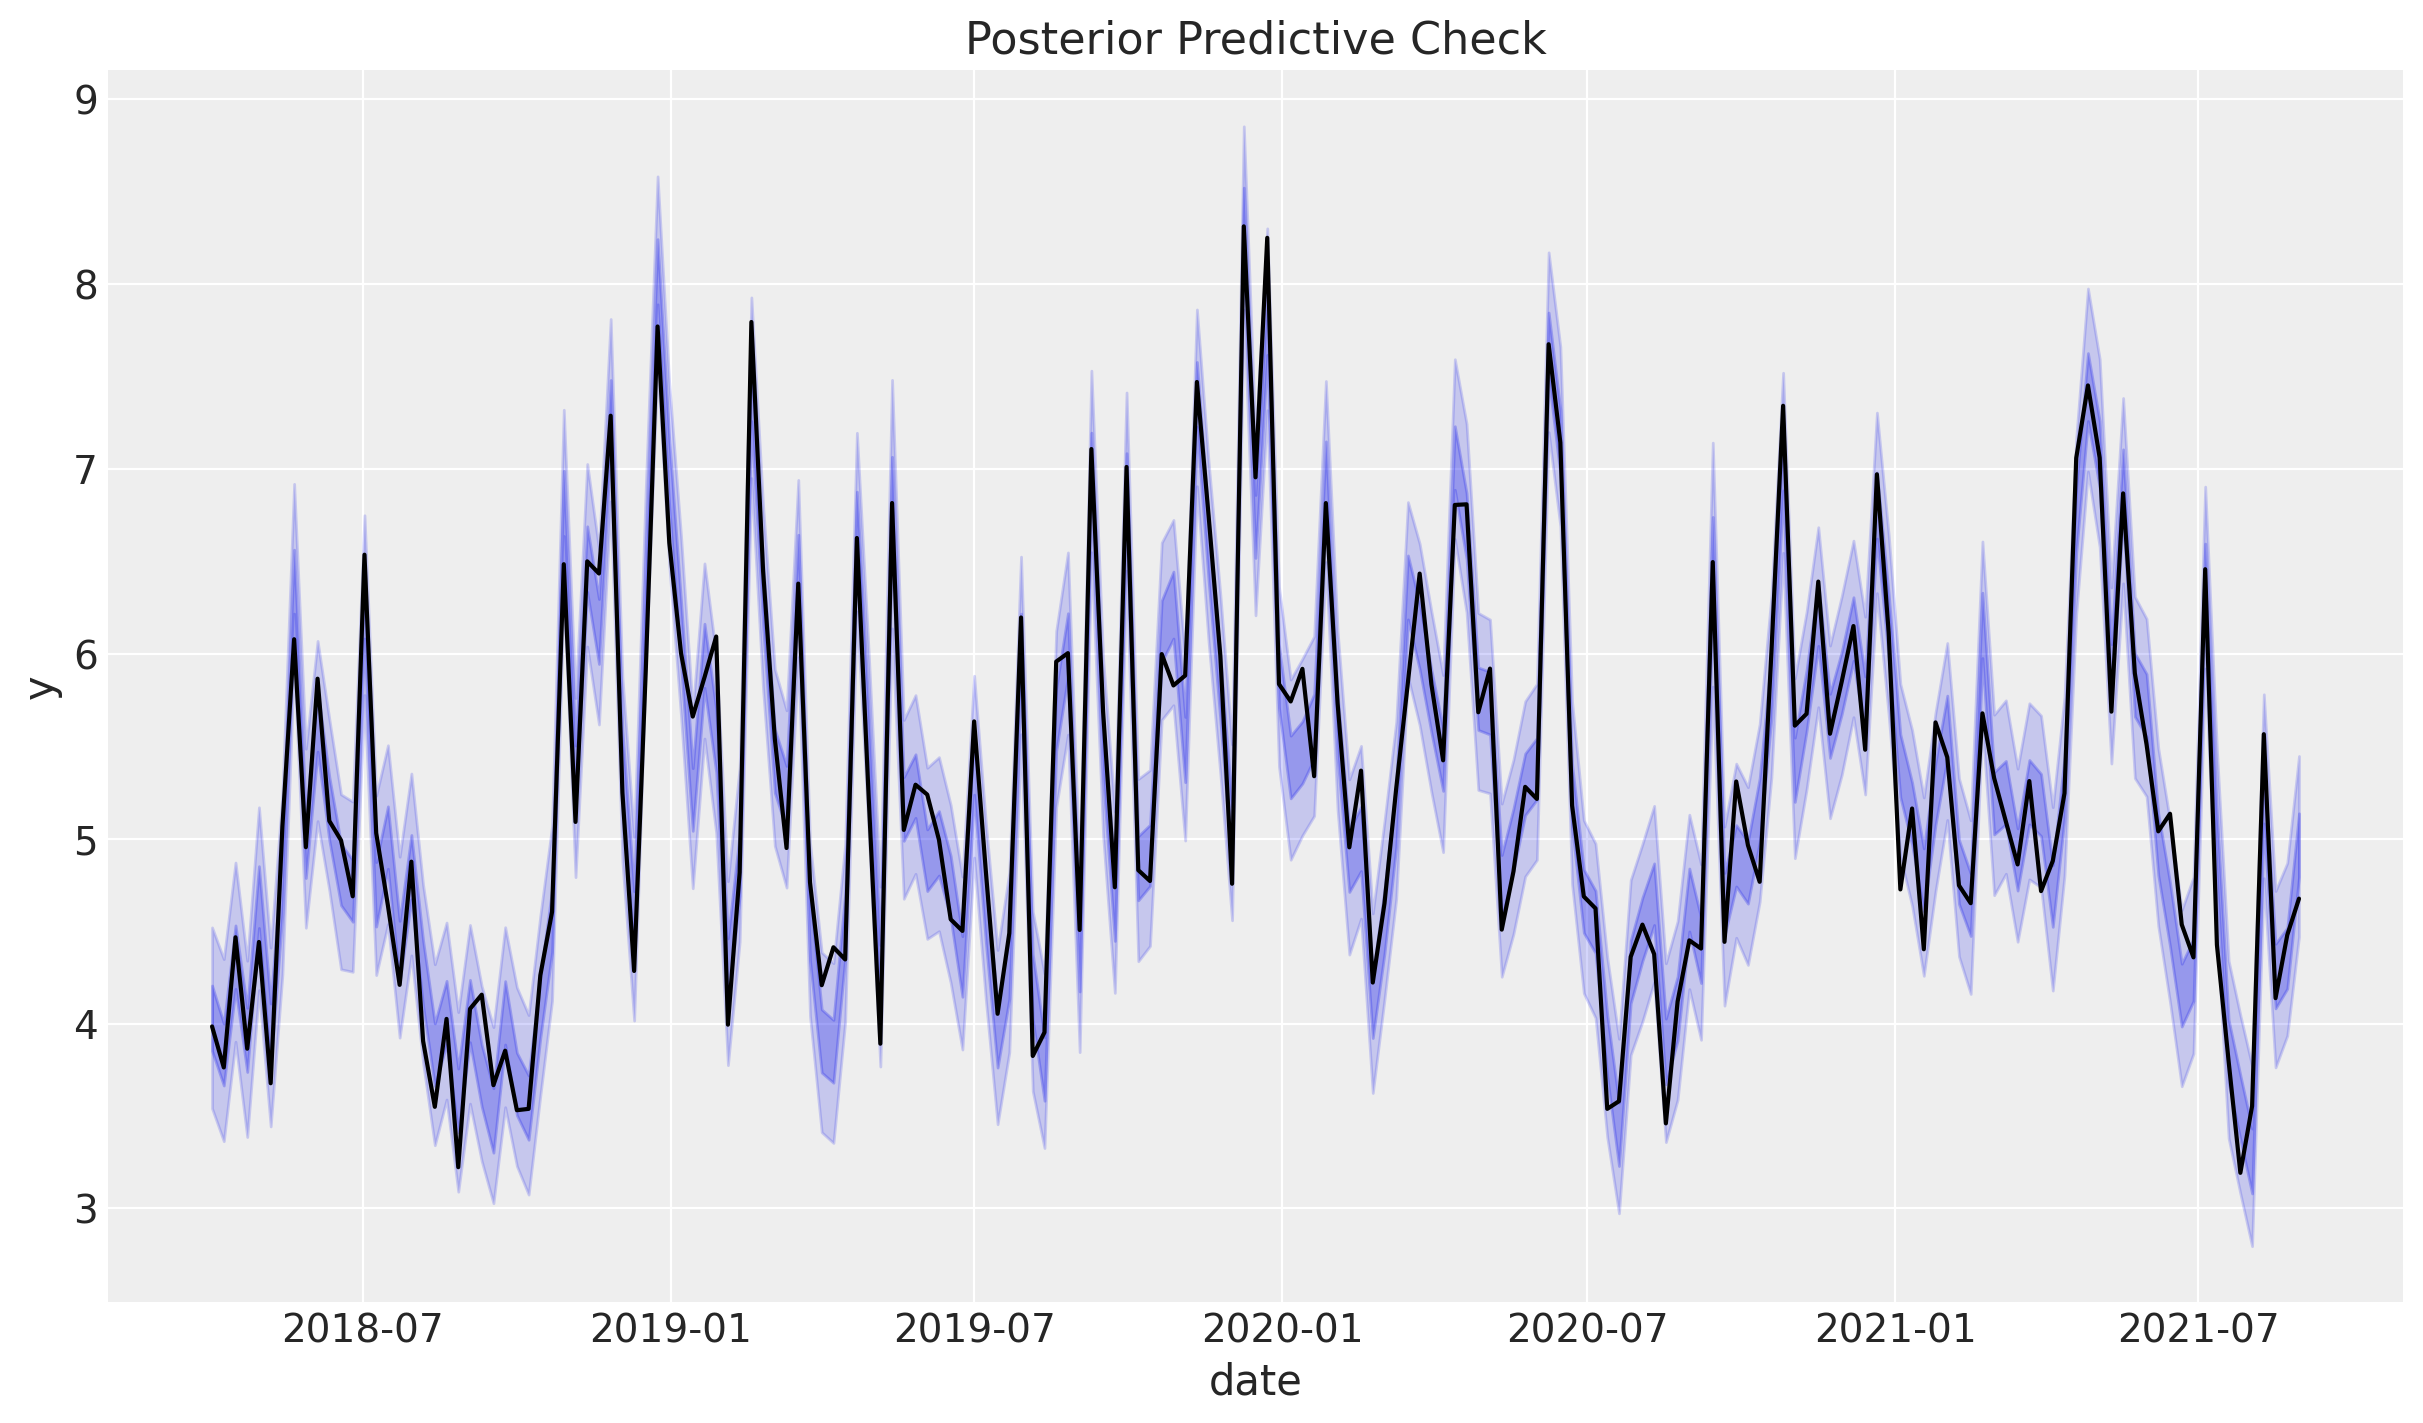

In [78]:
mmm.plot_posterior_predictive(original_scale=True);

The fit looks very good (as expected)!

We can decompose the posterior predictive distribution into the different components:

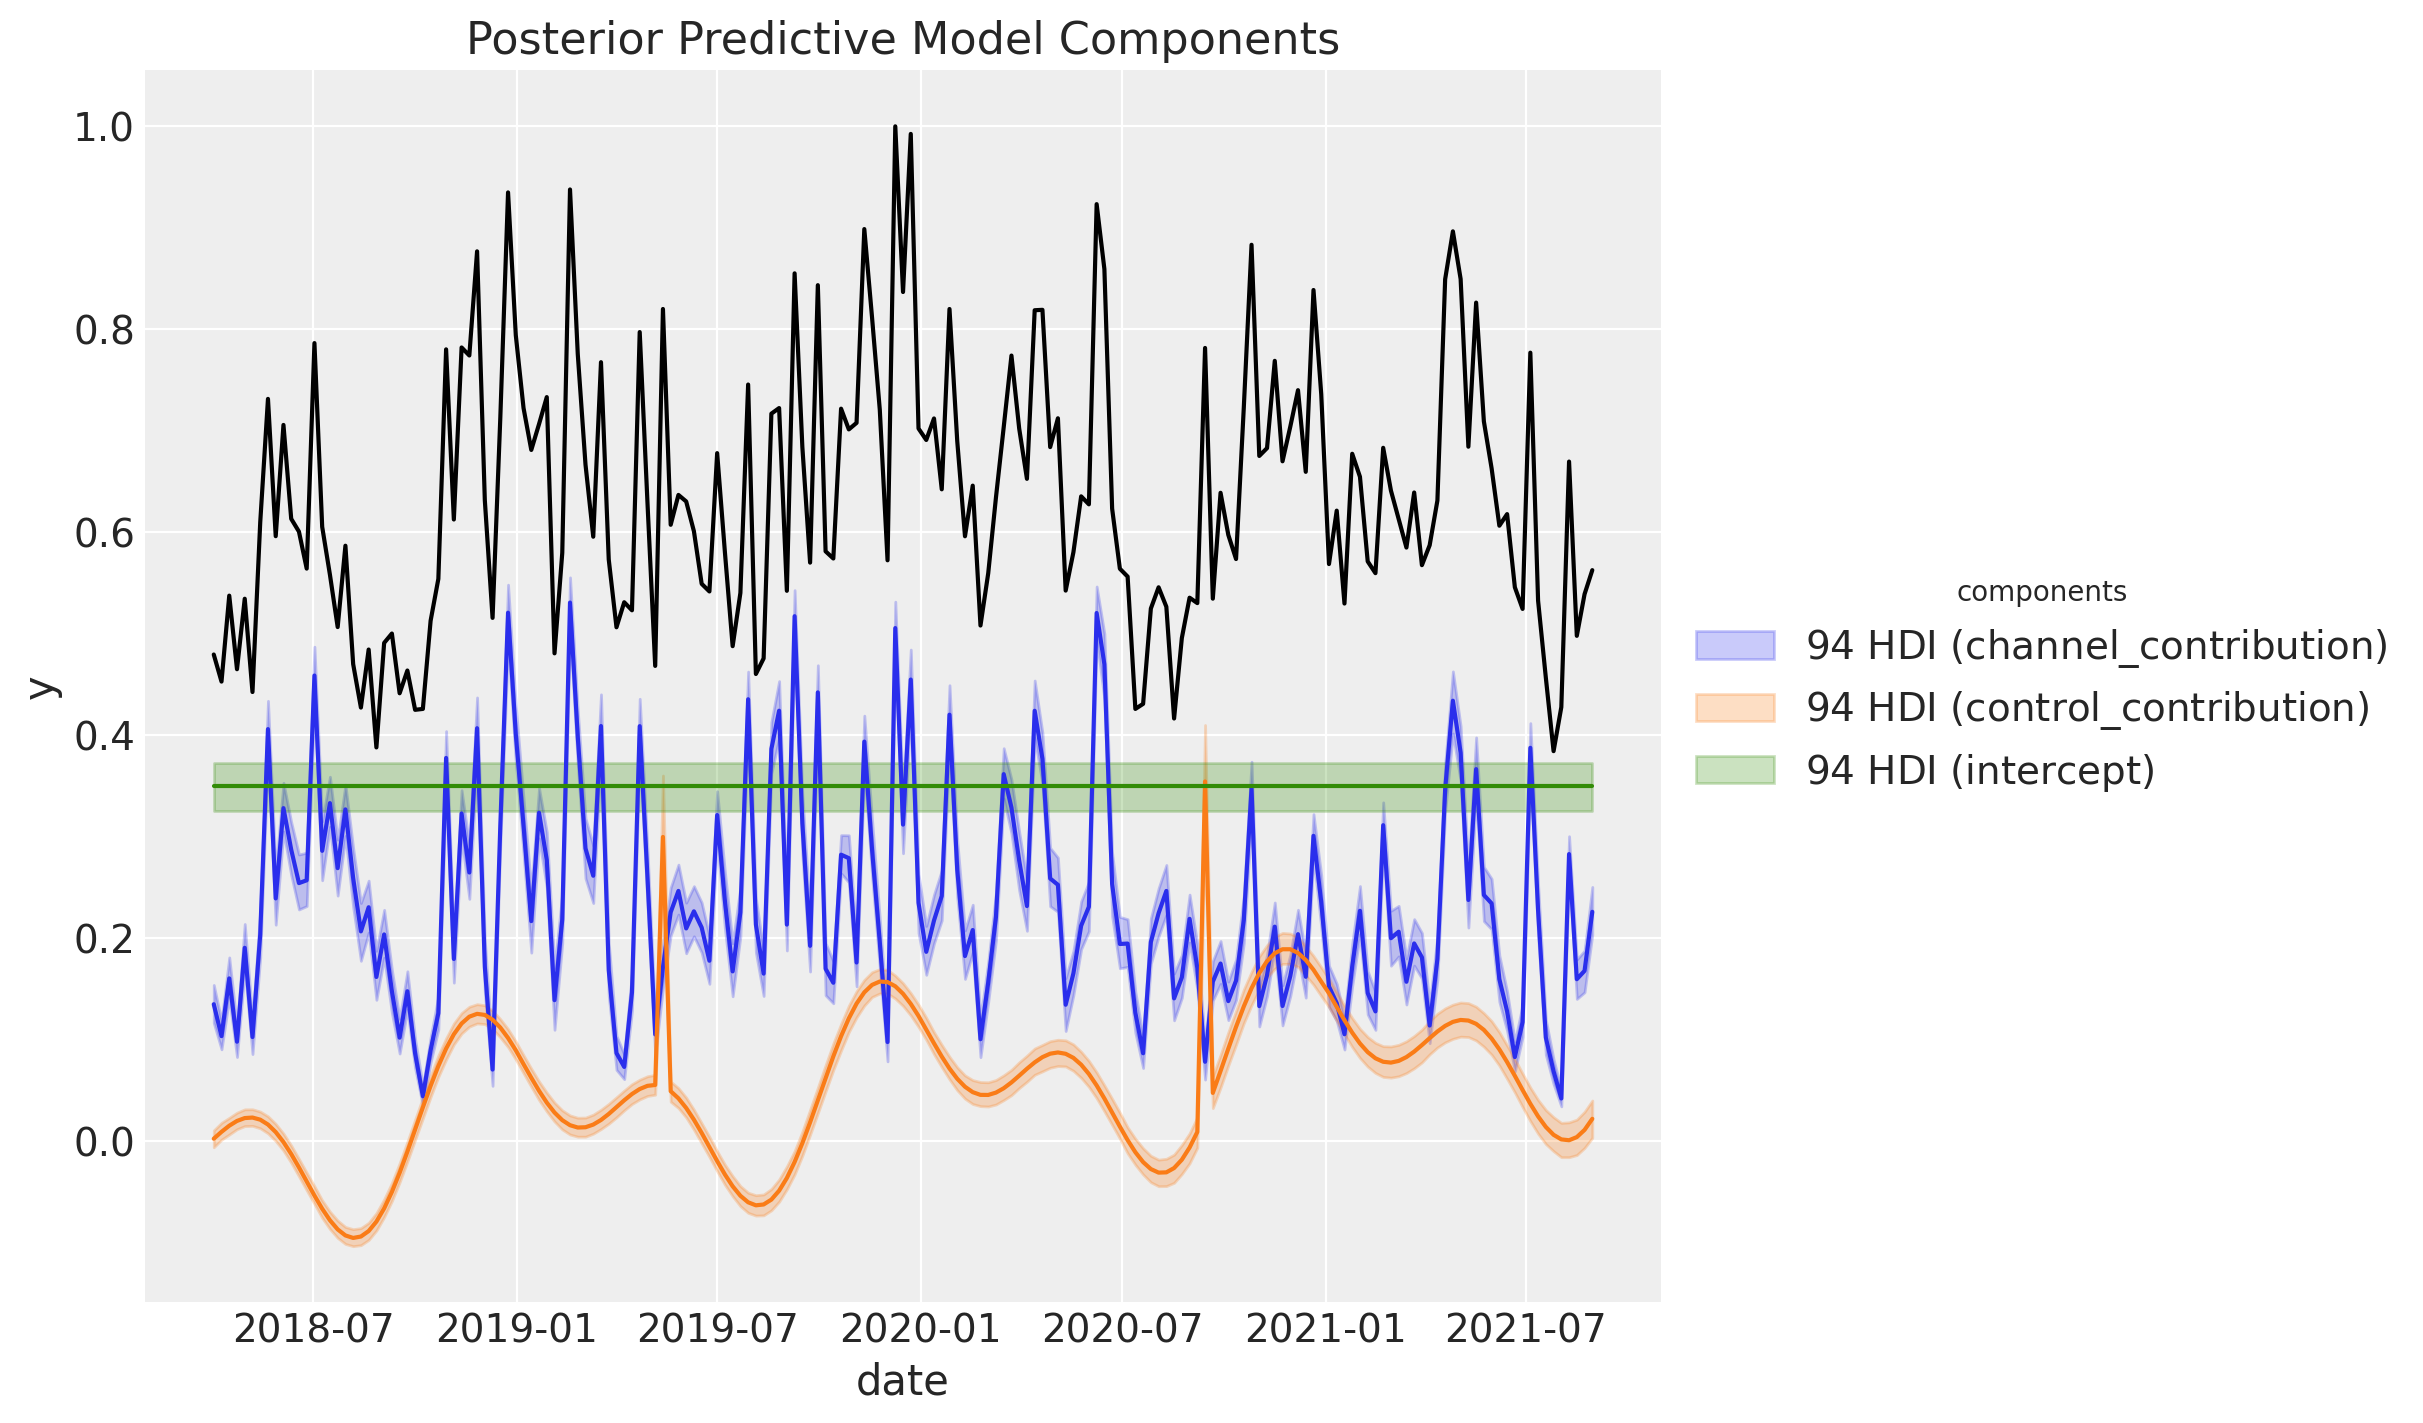

In [79]:
mmm.plot_components_contributions();

**Remark:** This plot shows the decomposition of the normalized target variable when by dividing by its maximum value. Internally, the model scales the variables to make the model sample more efficiently. You can recover the transformations from the API methods, e.g.

In [80]:
mmm.get_target_transformer()

Pipeline(steps=[('scaler', MaxAbsScaler())])

A similar decomposition can be achieved using an area plot:

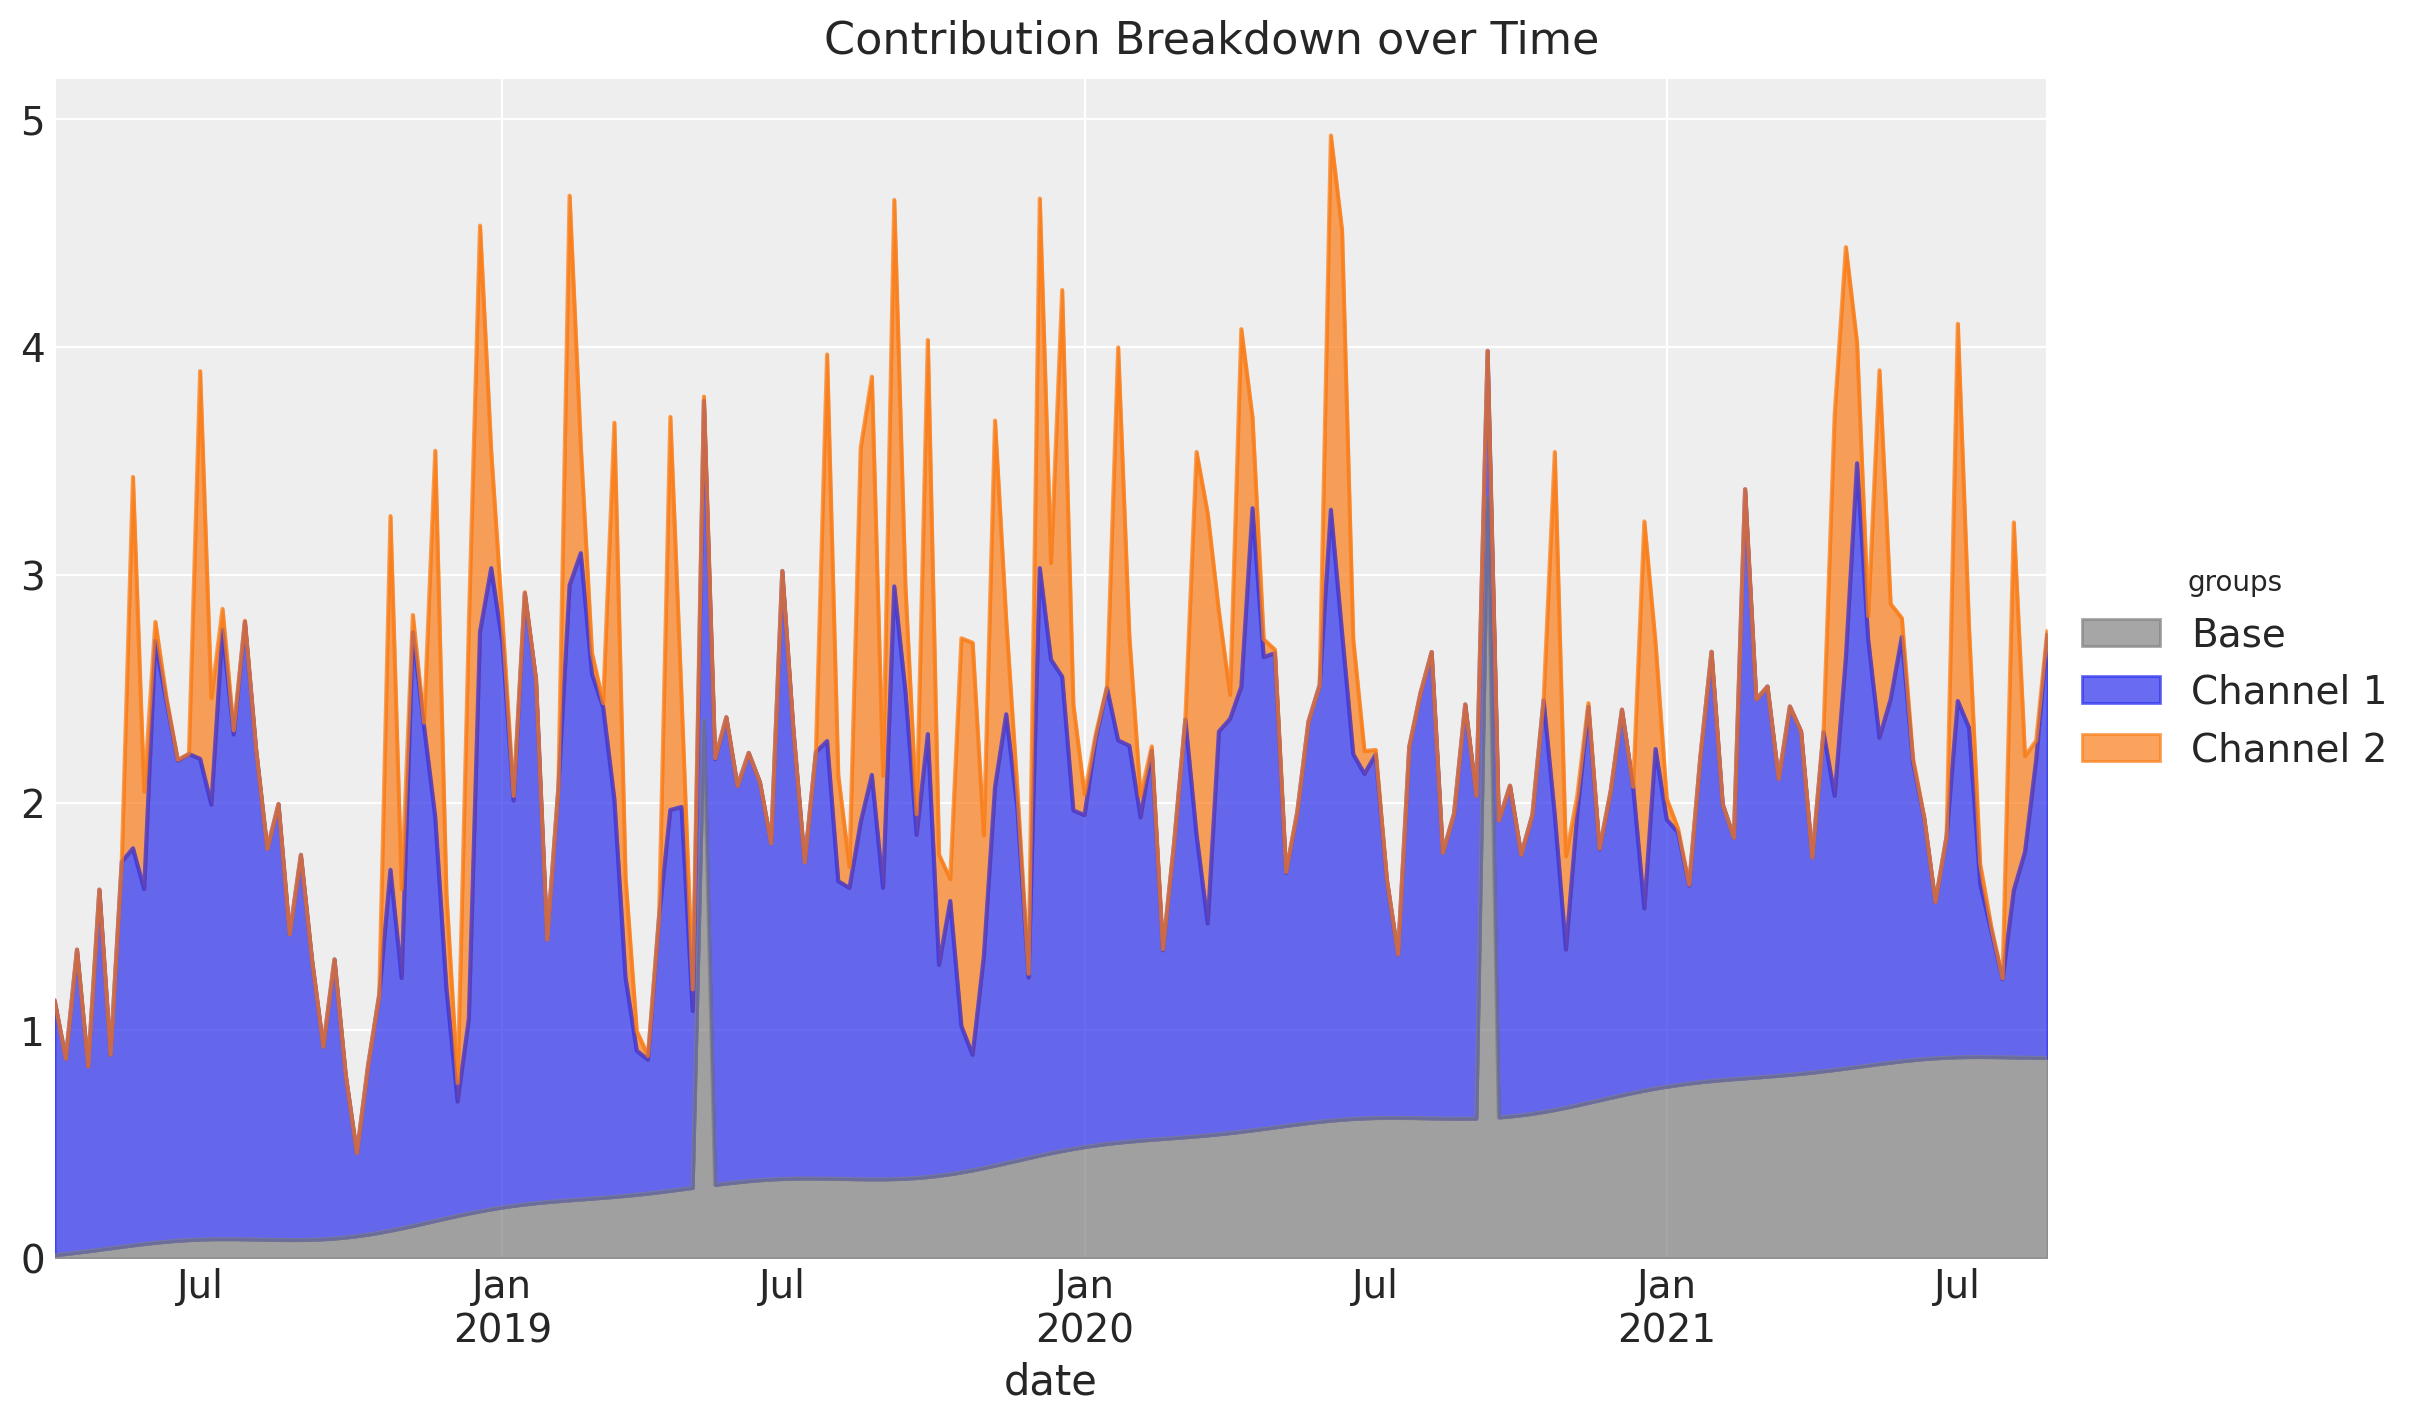

In [81]:
groups = {
    "Base": ["event_1", "event_2", "t", "sin_order_1", "cos_order_2"],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"]
}


fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    area_kwargs={"color": {"Channel 1": "C0", "Channel 2": "C1", "Base": "gray"}, "alpha": 0.7}
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

Note that this only works if the contributions of the channel or control variable are strictly positive.

## 5. Media Parameters

We can deep-dive into the media transformation parameters. We want to compare the posterior distributions against the true values.

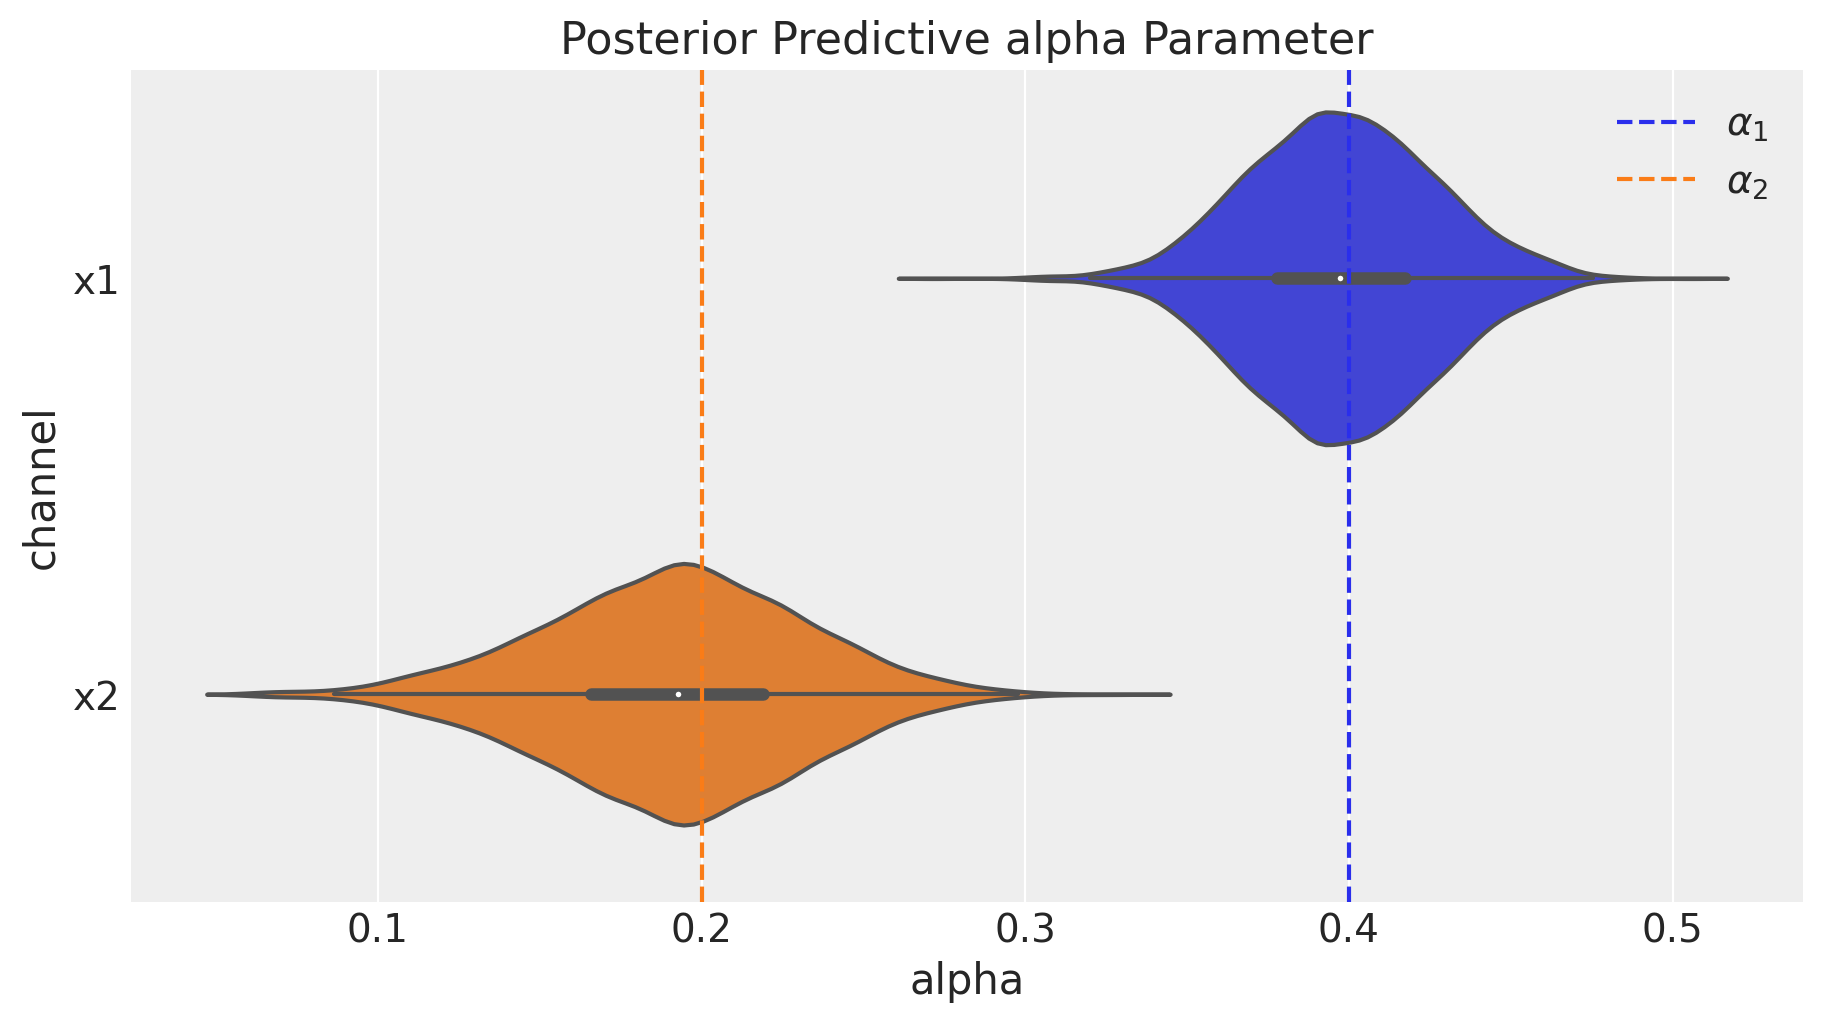

In [82]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

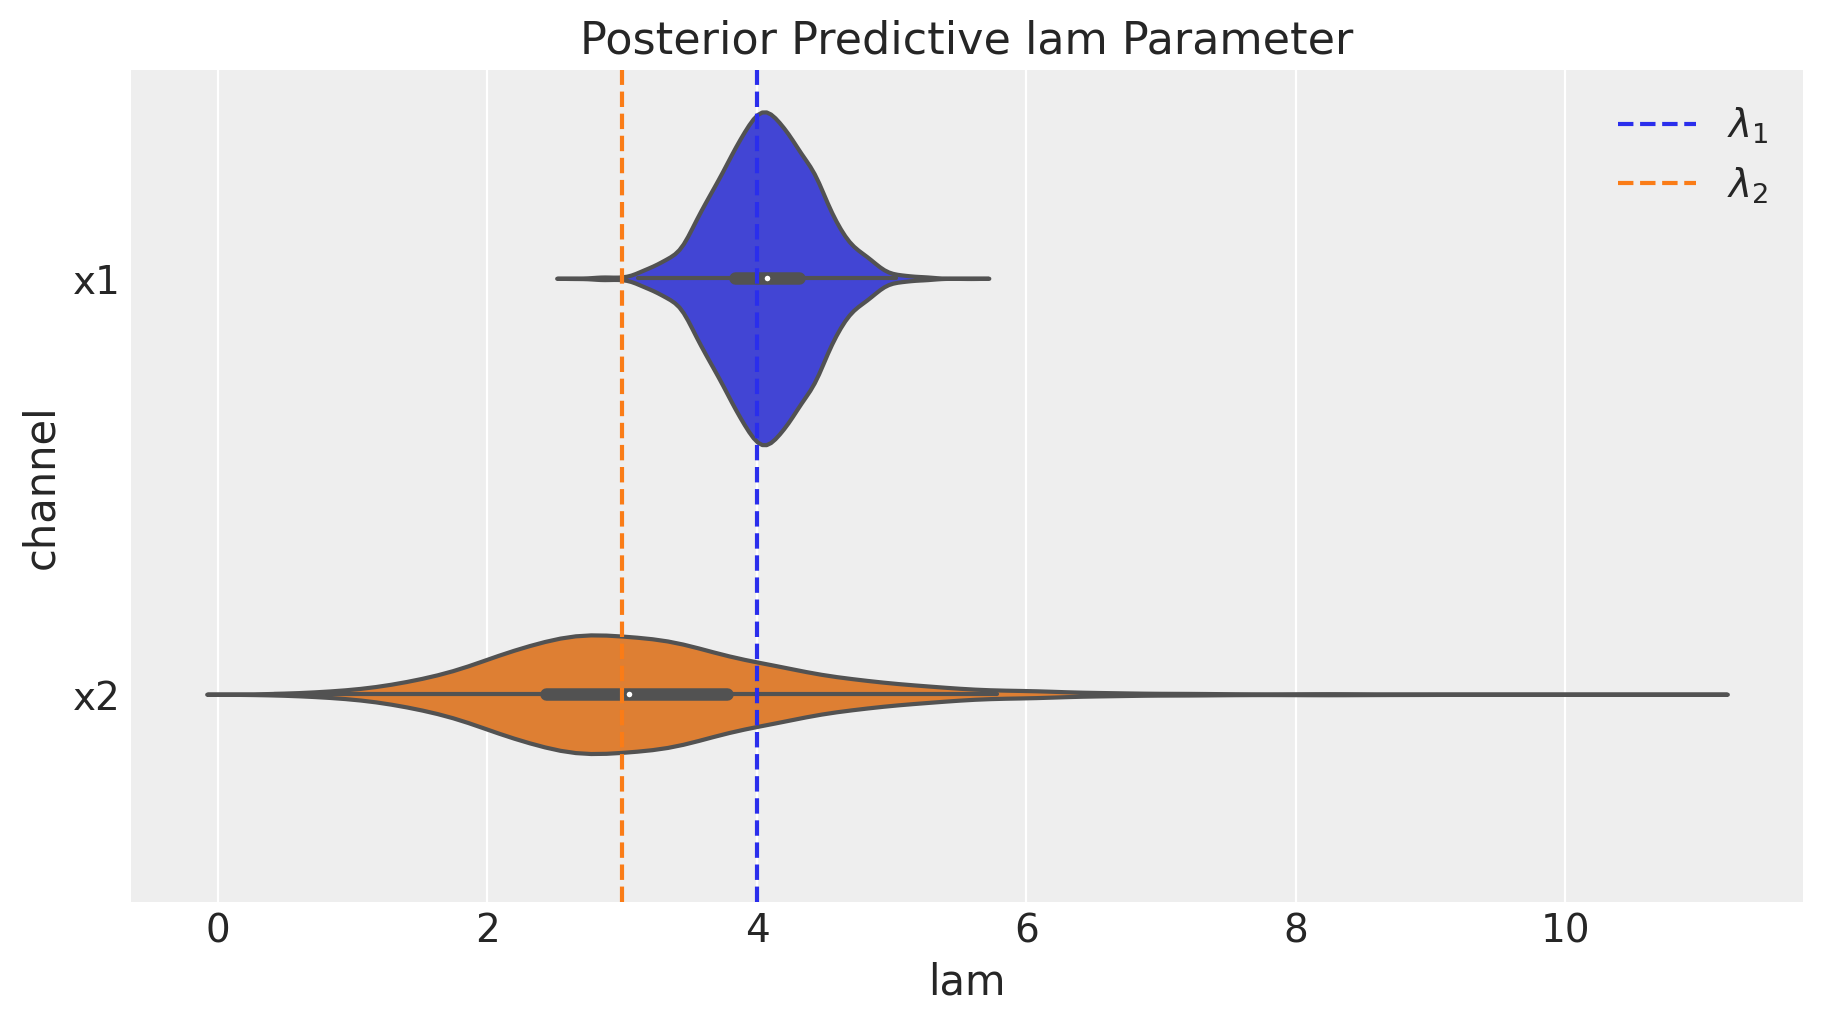

In [83]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

We indeed see that our media parameter were successfully recovered!

## 6. Media Deep-Dive

First we can compute the relative contribution of each channel to the target variable. Note that we recover the true values!

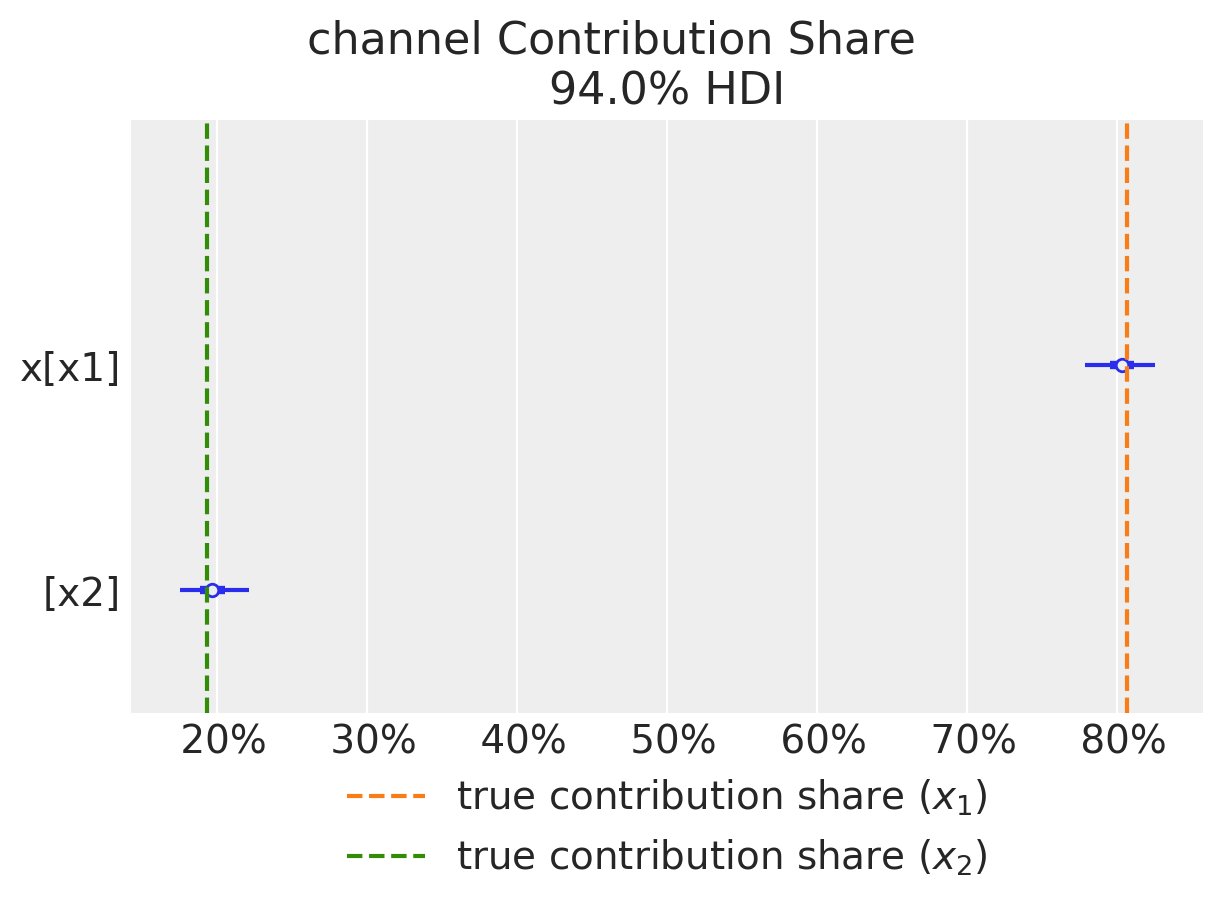

In [84]:
fig = mmm.plot_channel_contribution_share_hdi()
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

Next, we can plot the relative contribution of each channel to the target variable. Again, we get very close values as the ones obtained in Part I.

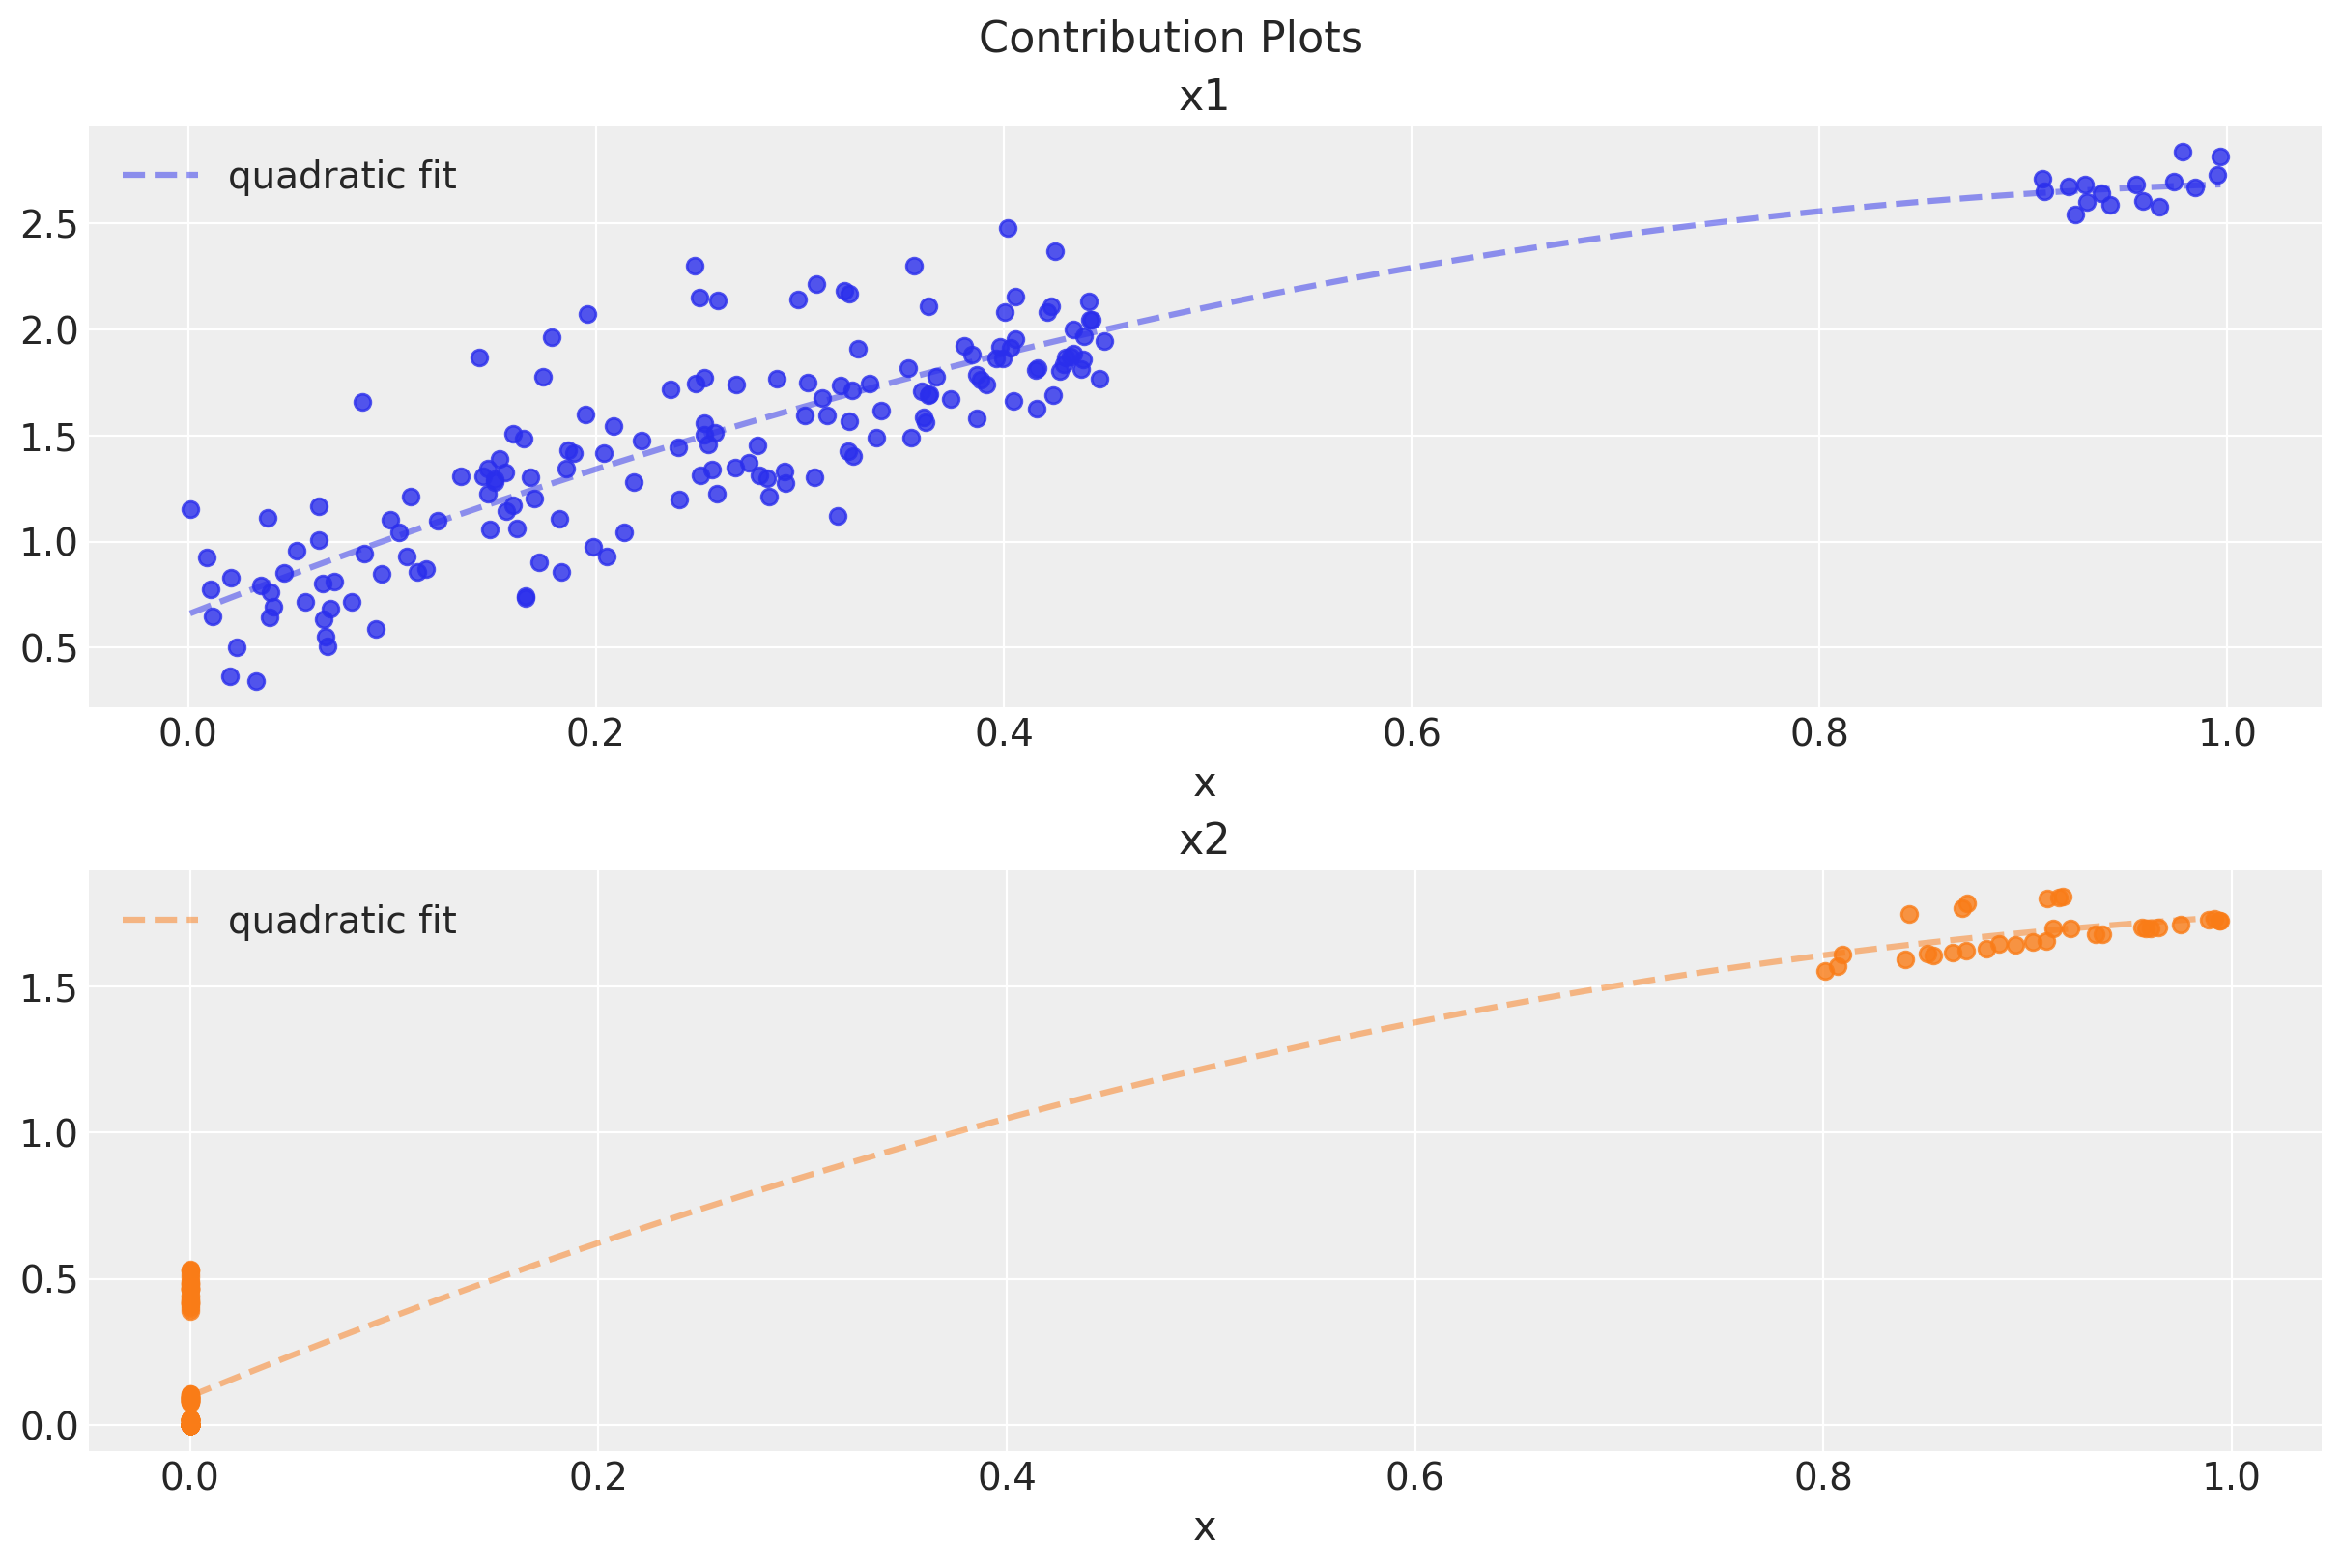

In [85]:
fig = mmm.plot_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

## 7. Contribution  Recovery

Next, we can plot the contribution of each channel to the target variable over time.

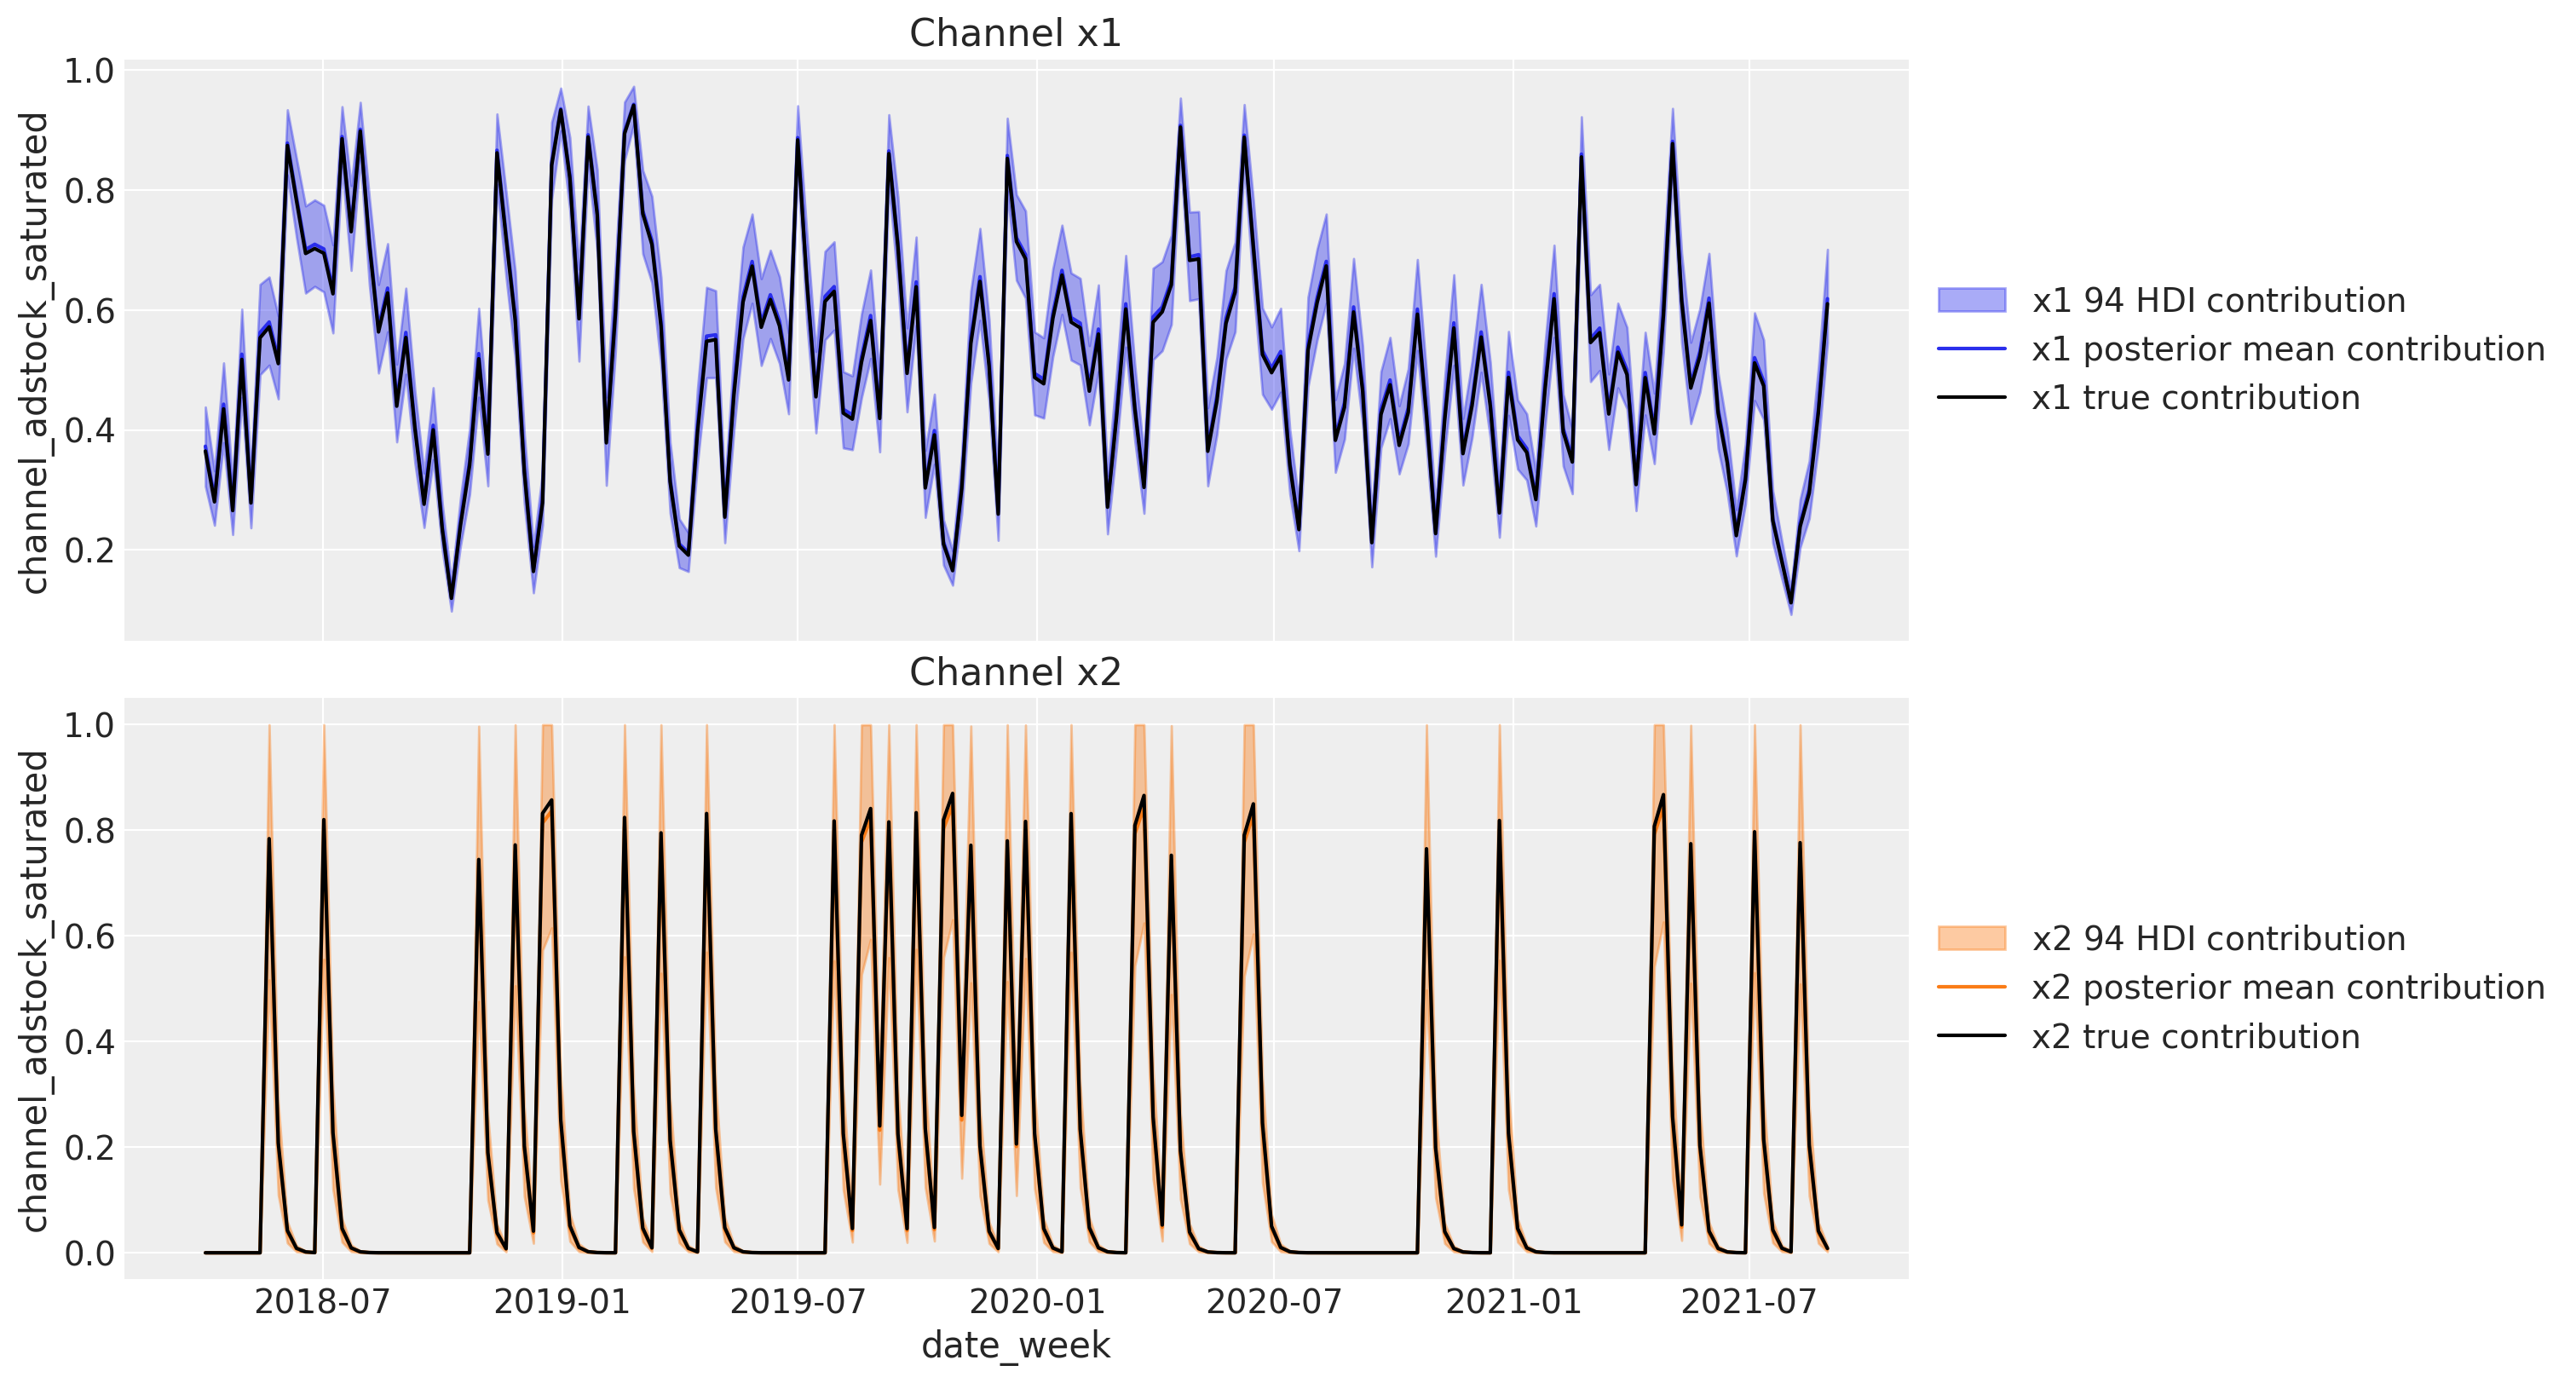

In [86]:
mean_estimated_channels_contribution = az.extract(
    data=mmm.fit_result,
    group="posterior",
    var_names=["channel_adstock_saturated"]
).mean("sample")

estimated_channels_contribution_hdi = az.hdi(ary=mmm.fit_result)["channel_adstock_saturated"]

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x, in enumerate(["x1", "x2"]):
    ax[i].fill_between(
        x=df["date_week"],
        y1=estimated_channels_contribution_hdi.sel(channel=x)[:, 0],
        y2=estimated_channels_contribution_hdi.sel(channel=x)[:, 1],
        color=f"C{i}",
        label=f"{x} $94%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x=df["date_week"],
        y=mean_estimated_channels_contribution.sel(channel=x),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        ax=ax[i]
    )
    sns.lineplot(
        x="date_week",
        y=f"{x}_adstock_saturated",
        data=df, color="black",
        label=f"{x} true contribution",
        ax=ax[i]
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

The results look great! We therefore successfully recovered the true values from the data generation process. We have also seen how easy is to use the `DelayedSaturatedMMM` class to fit media mix models! It takes over the model specification and the media transformations, while having all the flexibility of `pymc`!

## 8. ROAS

Finally, we can compute the (approximate) ROAS posterior distribution for each channel.

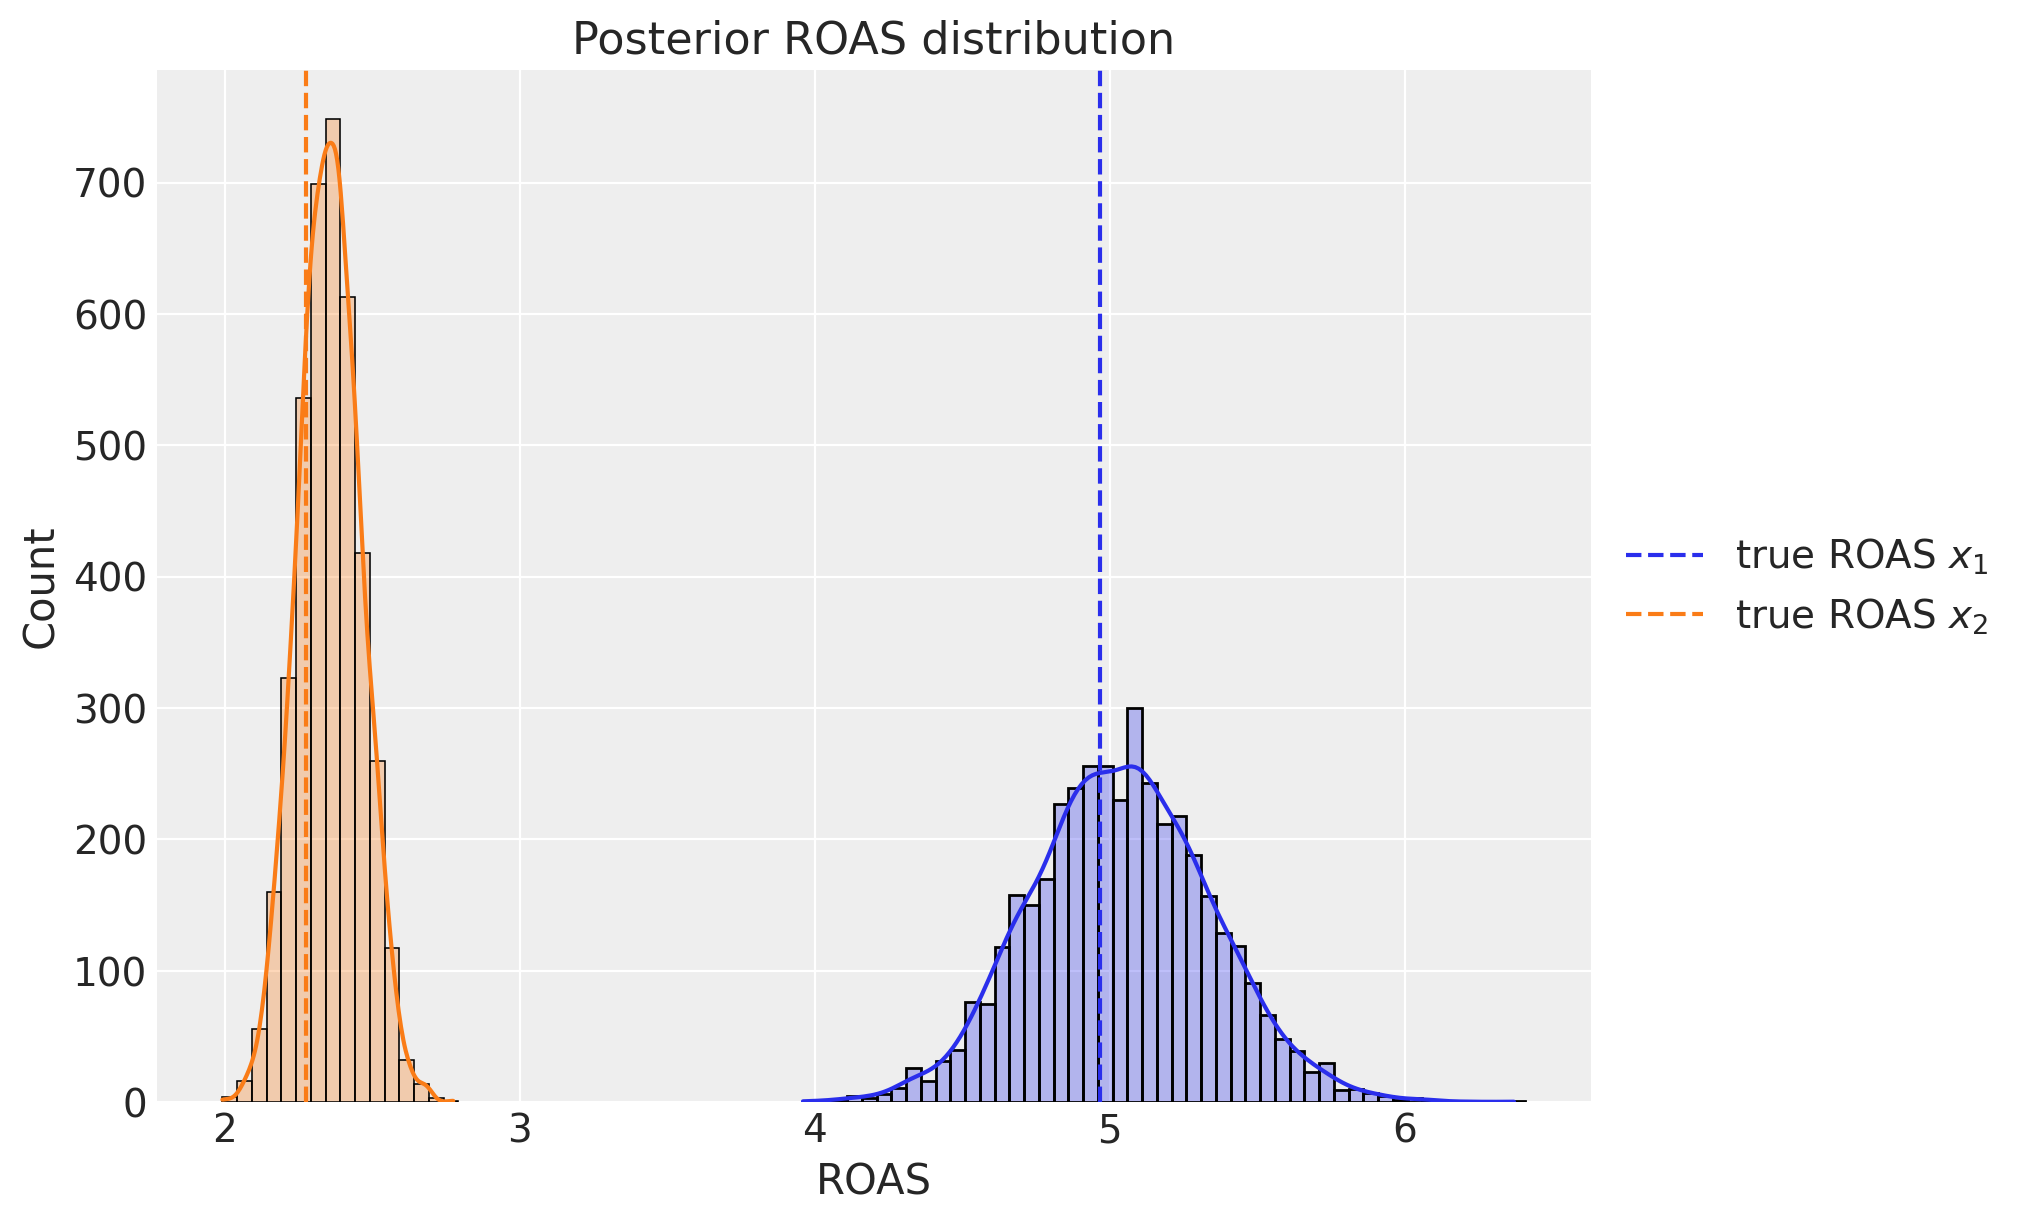

In [87]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(roas_samples.sel(channel="x1").to_numpy(), binwidth=.05, alpha=0.3, kde=True, ax=ax)
sns.histplot(roas_samples.sel(channel="x2").to_numpy(), binwidth=.05, alpha=0.3, kde=True, ax=ax)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

We see that the ROAS posterior distributions are centered around the true values! We also see that, even considering the uncertainty, channel $x_{1}$ is more efficient than channel $x_{2}$. 